<span style="color:orange; font-size:32px; font-weight:bold;">Robust PCA (RPCA) and Optimal Sensor Placement (OSP) applied on Cylinder Flow Data</span>

#### First, PCA is applied to the perturbed data to compare the results to RPCA. After RPCA is computed, the cleaned data (low-rank matrix $L$) is propagated to the OSP algorithm to find the optimal sensor positions. Afterward, the full image size is reconstructed using only 10 measurements.

### Import the dependencies

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import warnings
warnings.filterwarnings('ignore')
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as math
from matplotlib import animation, rc
from IPython.display import HTML, Image
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

In [3]:
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

## $\color{green}{\textbf{Switches for the perturbations (noise, outliers, and corruptions)}}$

#### Note that RPCA is poorly performing if the images are noisy. However, outliers and corruptions can be properly filtered.

In [4]:
noise_activate = False
outliers_activate = True
corruption_activate = True

-------------------------------------------------------
-------------------------------------------------------
-------------------------------------------------------

## $\color{blue}{\textbf{Adding Noise to the Data}}$ 

### Parameters

In [5]:
noise_distribution = 'Constant' # 'Gaussian'

# Parameters for Gaussian distribution
sigma_min = 0.8
sigma_max = 1.2

# Parameters for constant noise
noise_gain = 1.5

### Adding noise

In [6]:
def add_noise(data, gain = 1, data_compression = True):
    noise = 2 * gain * np.random.random(data.shape) - gain
    noisy_data = data + noise
    if data_compression:
        noisy_data = np.array(noisy_data, dtype=np.float32)
    return noisy_data, noise

# Gaussian noise distributed from weak (center) to severe (edges)
def add_gaussian_noise(image, sigma_max, sigma_min):
    # Add Gaussian noise to the image, with standard deviation varying from center to edges
    height, width = image.shape
    y, x = np.ogrid[:height, :width]
    center = height // 2, width // 2
    distance = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    max_distance = np.sqrt(center[1]**2 + center[0]**2)
    sigma = sigma_min + (sigma_max - sigma_min) * (distance / max_distance)
    noise = np.random.normal(0, sigma)
    noisy_image = np.clip(image + noise, 0, 255) #.astype(np.uint8)
    return noisy_image

## $\color{blue}{\textbf{Adding Outliers to the Data}}$ 

### Parameters

In [7]:
outlier_gain = 1
num_outliers = 10000
outliers_range = [30, 40]

### Adding outliers

In [8]:
def add_outliers(data, n_outliers, outliers_range):
    # Convert the data into a pandas DataFrame
    df = pd.DataFrame(data)

    # Indices of the outliers
    outlier_indices = np.random.choice(df.index, n_outliers, replace=False)

    for index in outlier_indices:
        # Randomly choose a column
        col = np.random.choice(df.columns)
        
        # Add an outlier to the existing data
        if np.random.rand() > 0.5:
            df.at[index, col] = np.random.uniform(*outliers_range)
        else:
            df.at[index, col] = -np.random.uniform(*outliers_range)
            
    return df.values, outlier_indices

## $\color{blue}{\textbf{Corrupting Data}}$ 

### Parameters

In [9]:
# Define the proportion of data to corrupt
proportion_to_corrupt = 0.1  # 10%

-------------------------------------------------------
-------------------------------------------------------
-------------------------------------------------------

In [10]:
contents=sio.loadmat('./data/CYLINDER_ALL.mat')
VORTALL = contents['VORTALL']
X_clean = VORTALL[:,:]
X  = np.copy(X_clean)

## Plotting snapshots

In [11]:
def plot(s,r,name=None):
    theta = np.linspace(0,1,100)
    theta = theta * 2*22.0/7.
    x = 49.0+25.0*np.sin(theta)
    y = 99.0+25.0*np.cos(theta)
    for i in range(r):
        plt.figure(figsize = (20,30))
        im = plt.imshow(np.real(s[:,:,i].T),cmap='seismic')
        plt.fill(x,y)
        # Compute the maximum absolute value in the data
        #clim = max(abs(s.min()), s.max())
        #clim = max(-40, 40)
        # Set the color limits to extend the same amount in both directions from zero
        #im.set_clim(-clim, clim)
        #plt.colorbar(im)
        
        #plt.axis('off')
        plt.xticks([])  # Remove x-axis labels
        plt.yticks([])  # Remove y-axis labels
        if name != None:
            filename = './fig/'+name+'_'+str(i+1)+'.pdf'
            plt.savefig(filename,bbox_inches="tight")      
        plt.show()         

### Read the simulation results

In [12]:
nx,ny,m,n = contents['nx'],contents['ny'],contents['m'],contents['n']
m, n = np.asscalar(m), np.asscalar(n)
nx, ny = np.asscalar(nx), np.asscalar(ny) 
print(X.shape)

(89351, 151)


-------------------------------------------------------
-------------------------------------------------------
-------------------------------------------------------

## $\color{blue}{\textbf{Clean Images (without perturbations)}}$ 

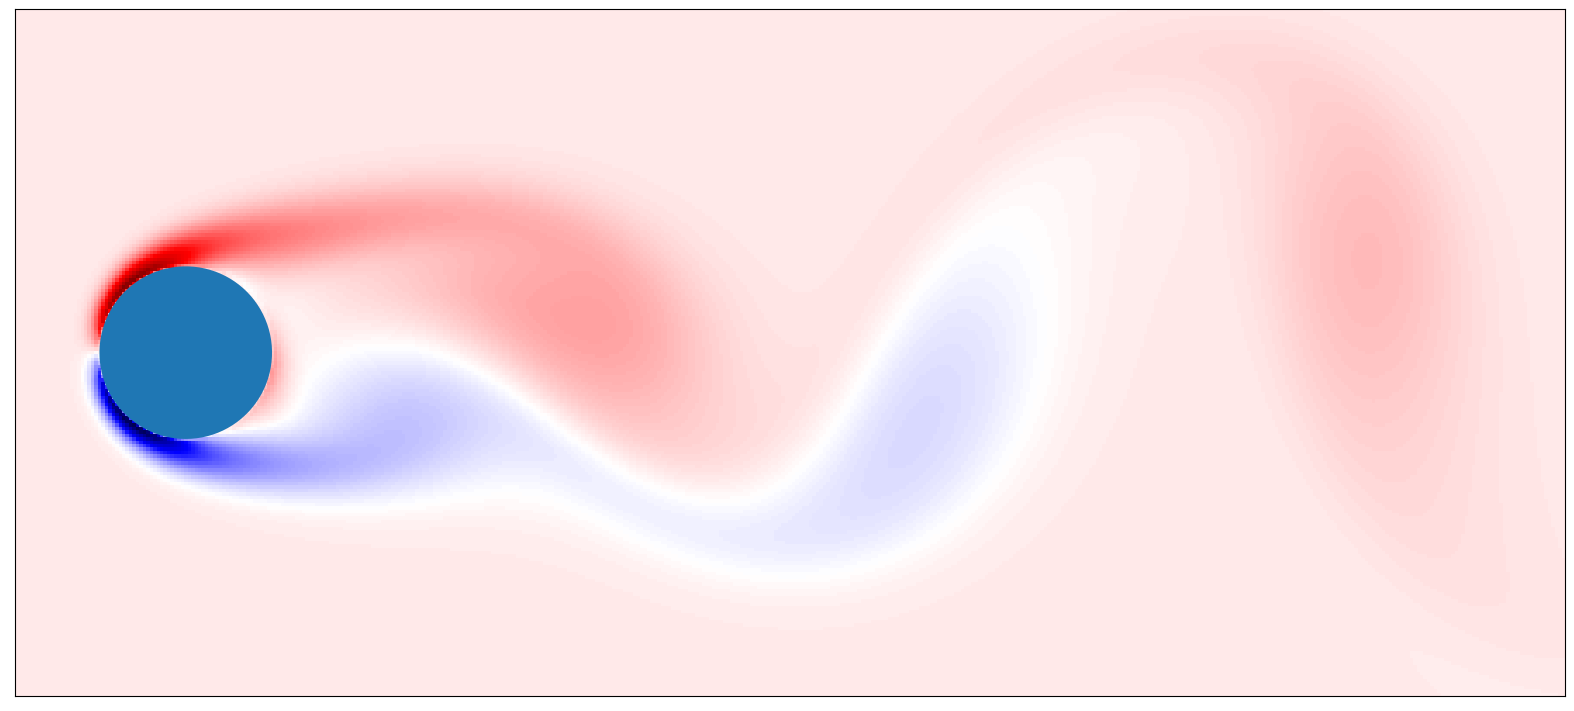

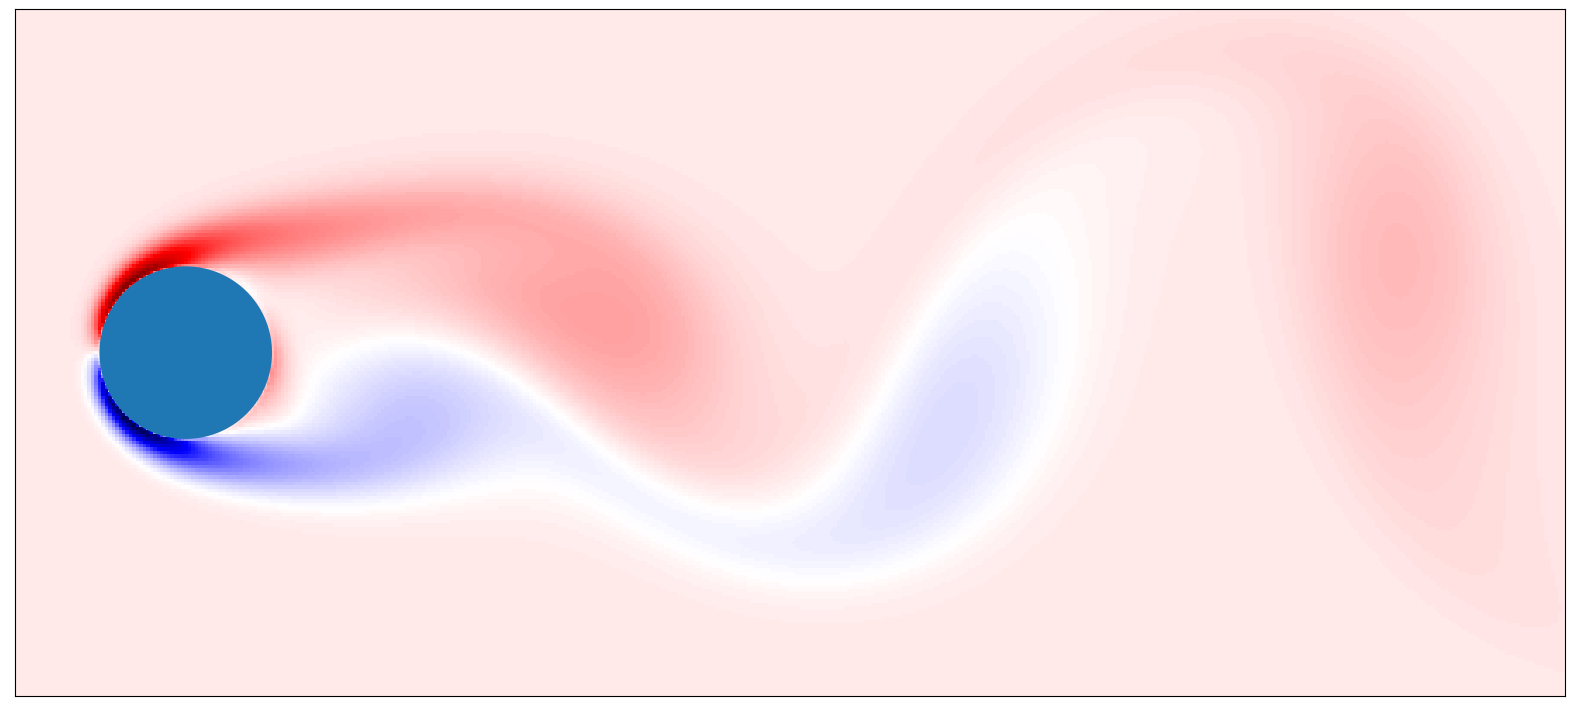

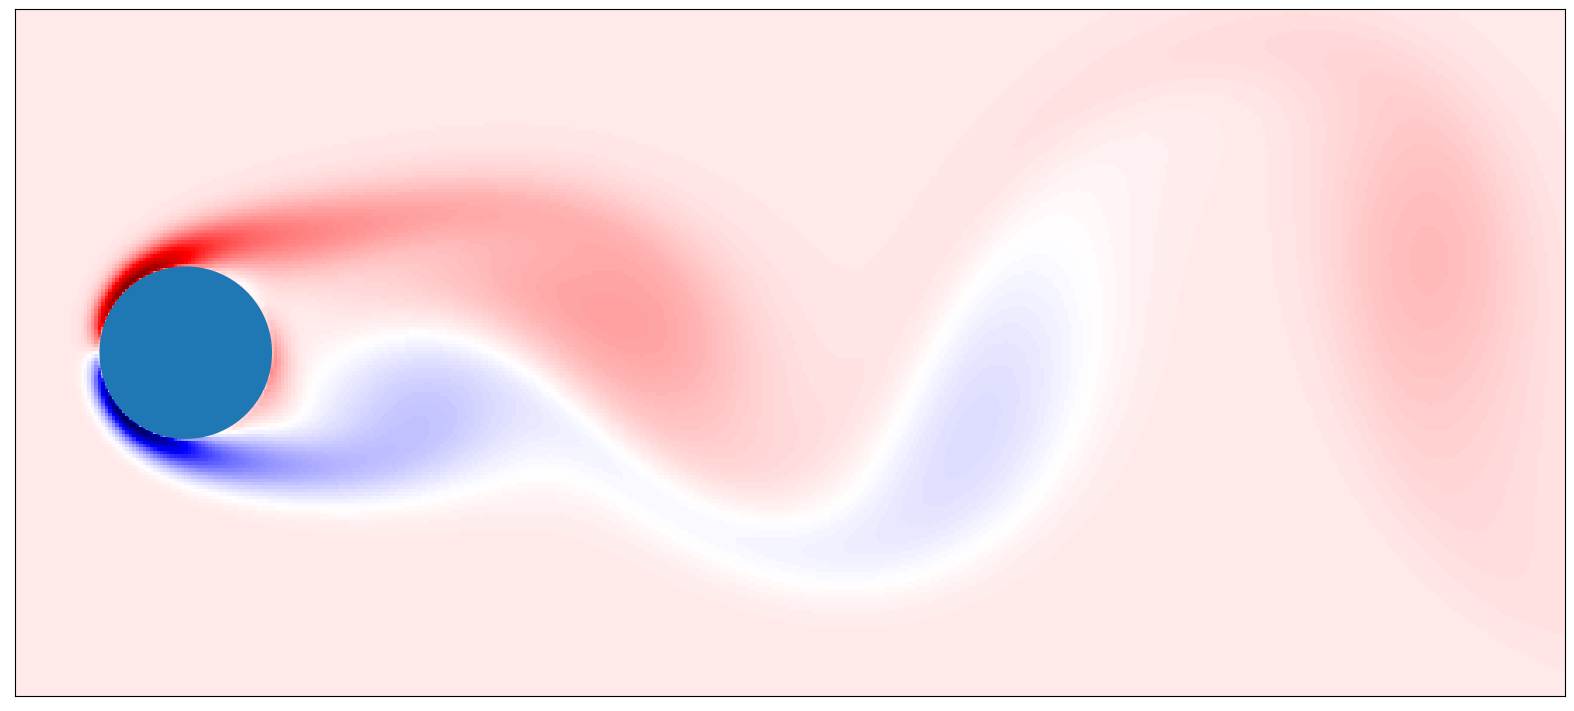

In [13]:
X_image_clean = np.reshape(X_clean,(ny,nx,151))
plot(X_image_clean,3,'Image_clean')

## $\color{blue}{\textbf{Clean Modes}}$ 

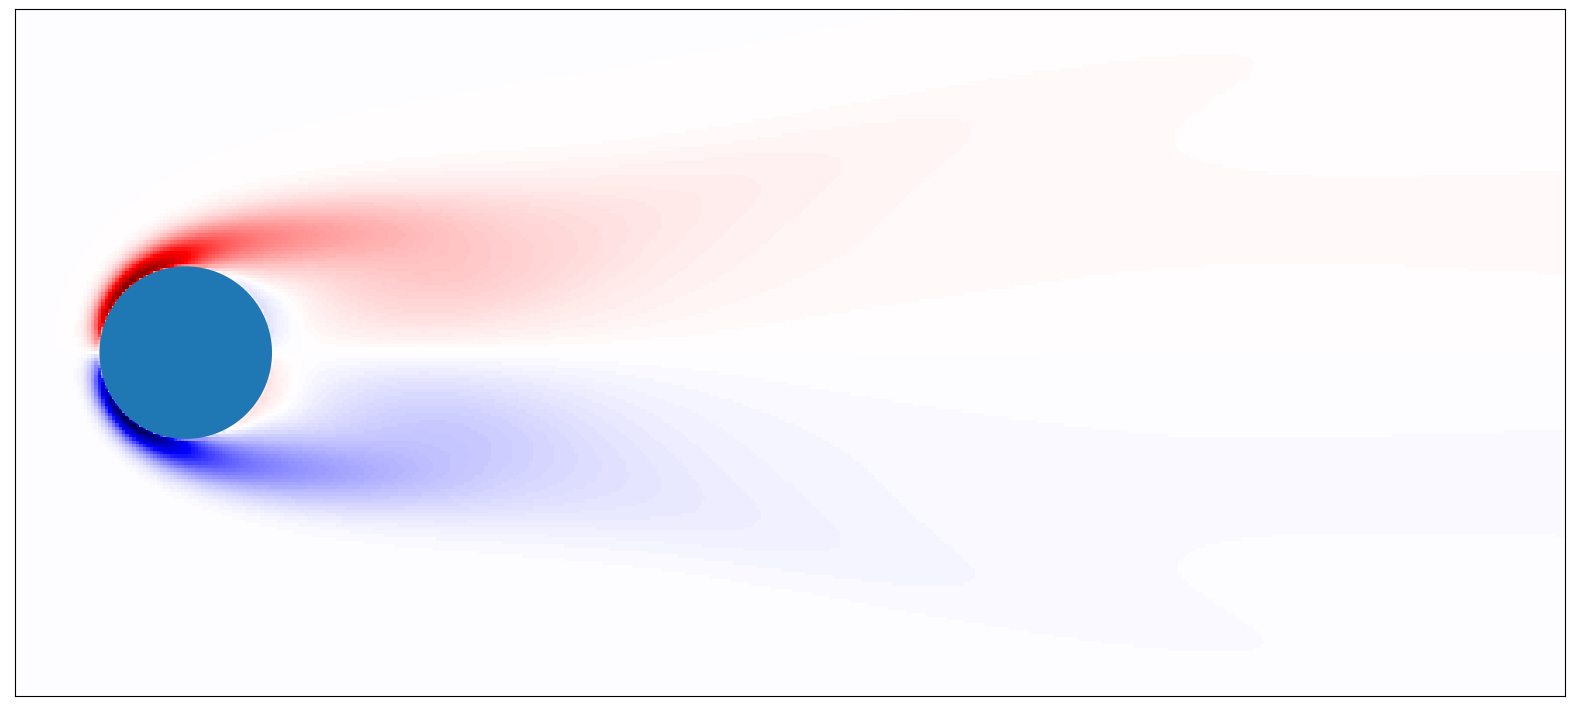

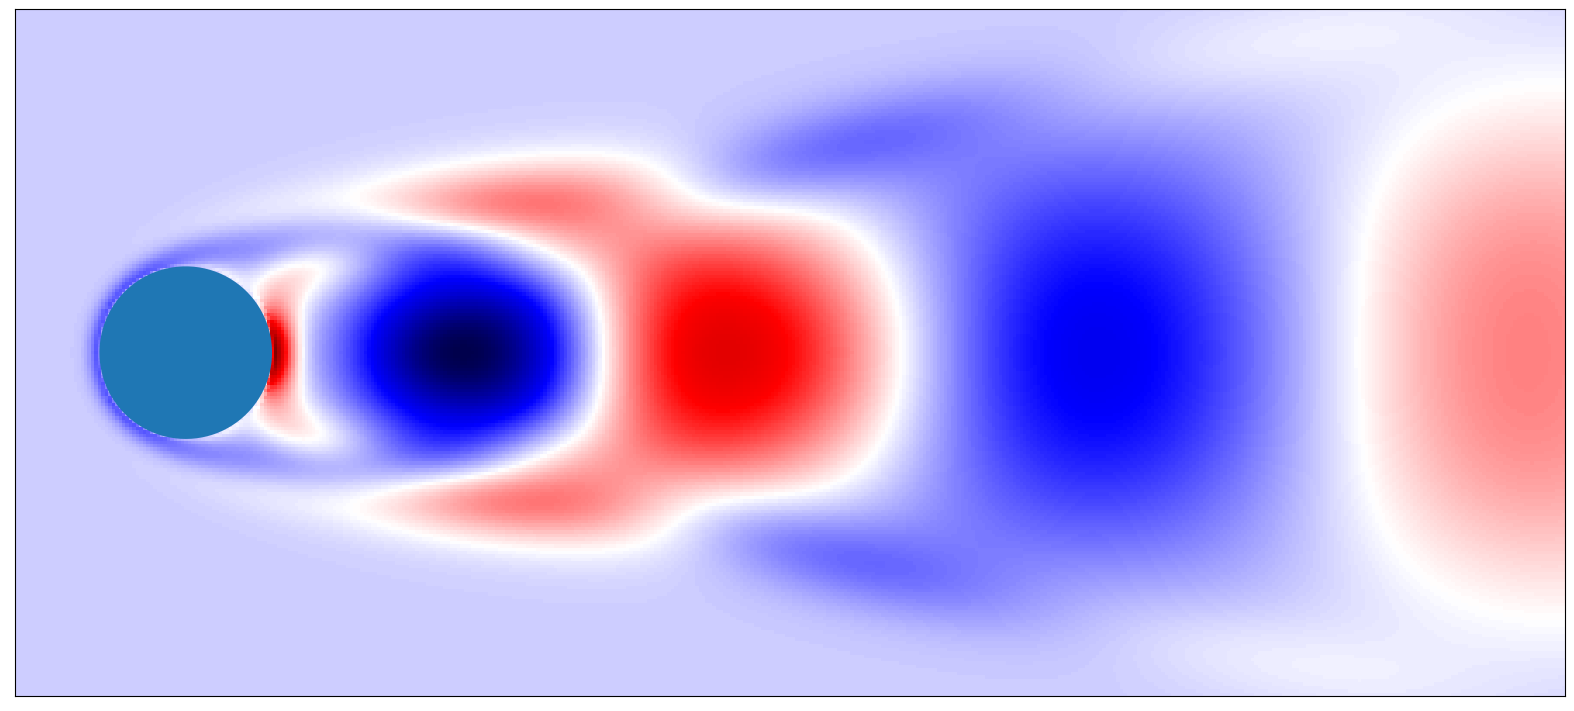

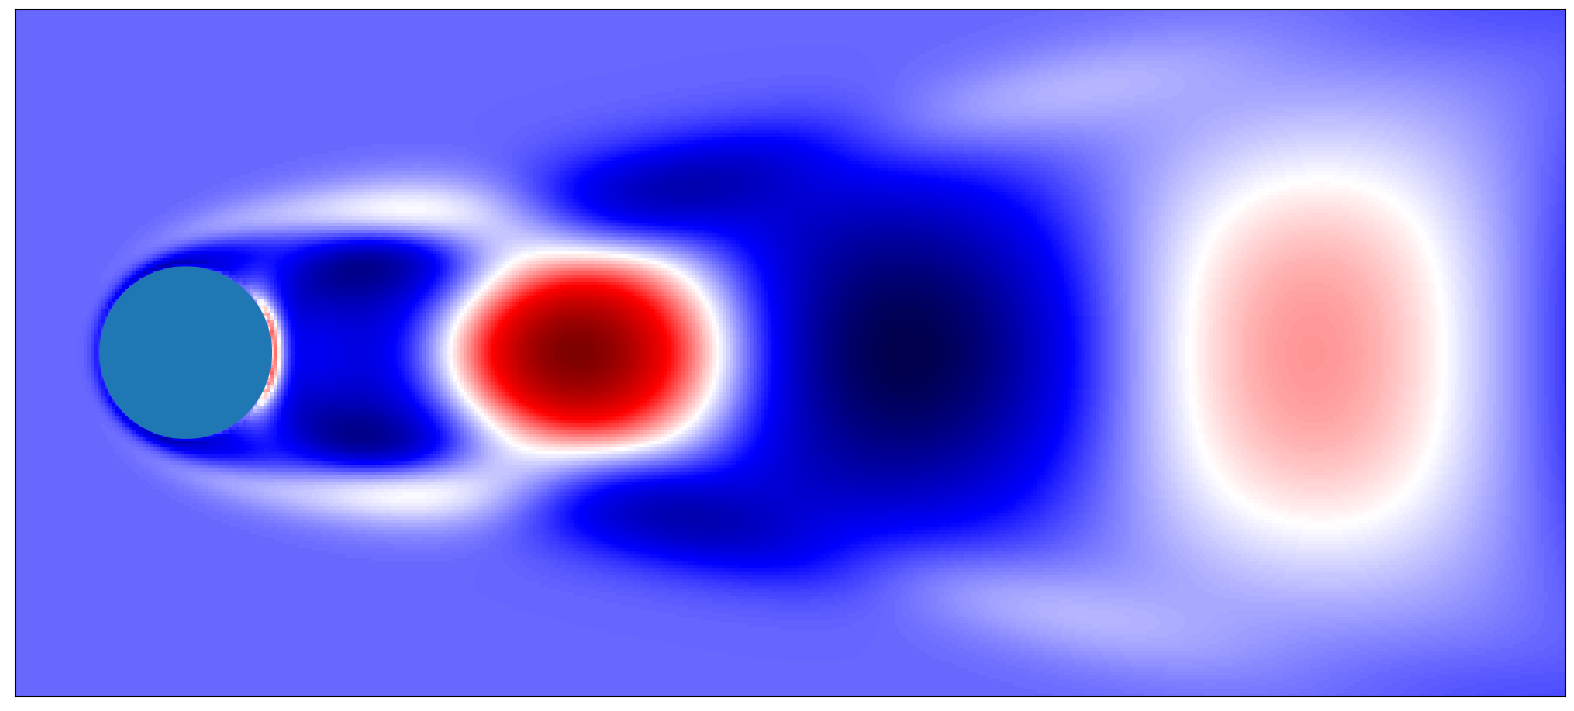

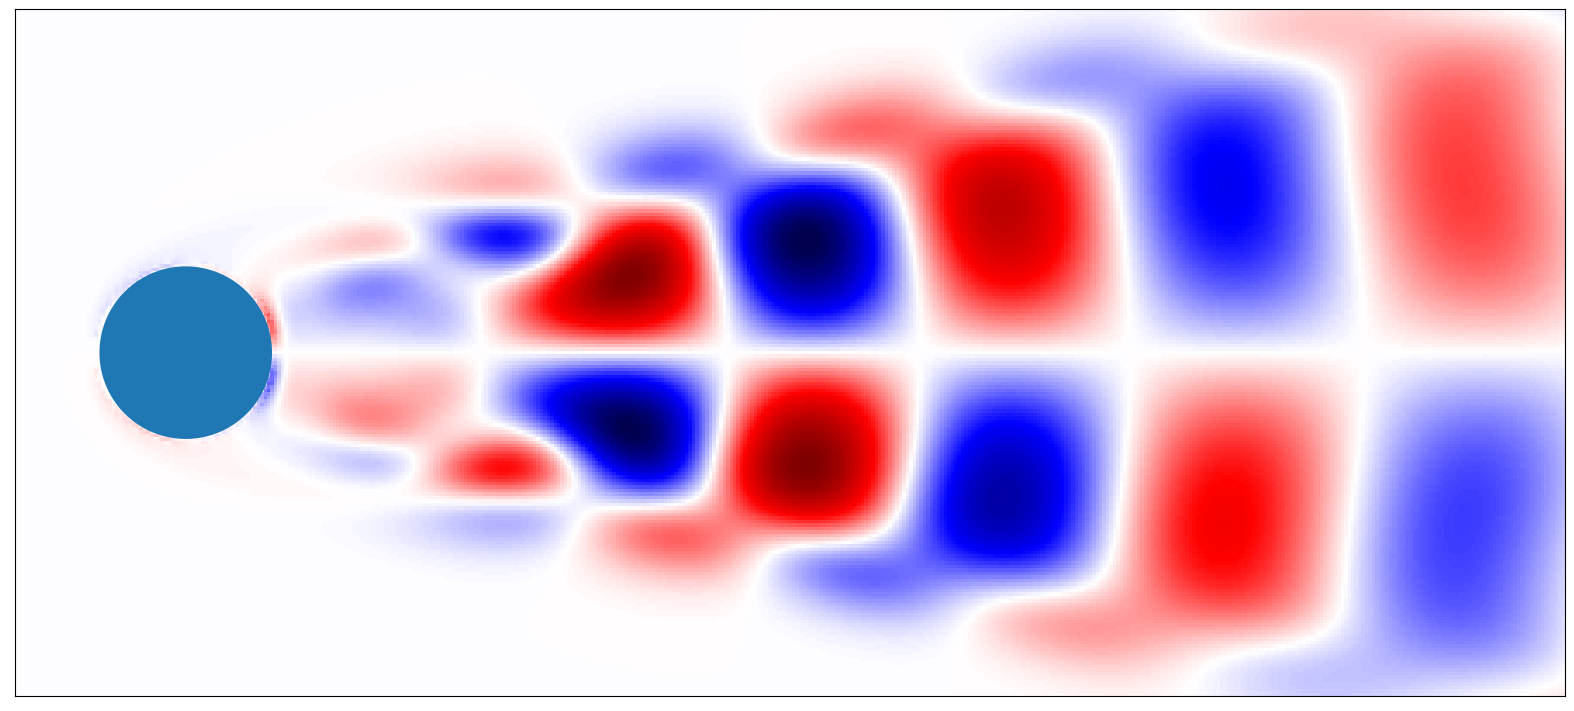

In [14]:
num_components = 10

# Robust PCAfrom sklearn.decomposition import PCA
pca = PCA(n_components = num_components)  # project from 64 to 2 dimensions
score=pca.fit_transform(X_clean)
coeff=pca.components_ #eigen vectors.T
latent = pca.explained_variance_
explained = pca.explained_variance_ratio_
Phi = np.reshape(score,(ny,nx,num_components))

plot(Phi,4,'True_modes')

-------------------------------------------------------
-------------------------------------------------------
-------------------------------------------------------

## $\color{blue}{\textbf{Measurements}}$ 

**Here the actual perturbations are added to the cleaned data**

In [15]:
if noise_activate == True:
    if noise_distribution == 'Constant':
        X, noise = add_noise(X, gain = noise_gain, data_compression = False)
    if noise_distribution == 'Gaussian':
        X = X.reshape((ny, nx, 151))
        noisy_images = np.zeros((ny, nx, X.shape[2]))    
        for i in range(X.shape[2]):
            noisy_images[:,:,i] = add_gaussian_noise(X[:,:,i], sigma_max, sigma_min)
        noise = X.reshape((ny, nx, 151)) - noisy_images
        X = noisy_images.reshape(X_clean.shape)
    
if outliers_activate == True:
    X, outlier_indices = add_outliers(X, num_outliers, outliers_range)
    
if corruption_activate == True:
    # Calculate the number of elements to corrupt
    num_elements = X.size
    num_to_corrupt = int(proportion_to_corrupt * num_elements)

    # Generate random indices to corrupt
    indices = np.random.choice(num_elements, num_to_corrupt, replace=False)

    # Convert 1D indices to 2D indices
    rows, cols = np.unravel_index(indices, X.shape)

    # Generate corrupted data
    # This example uses large random values as the corrupted data
    corrupted_data = np.random.normal(10, 5, size=num_to_corrupt)

    # Replace the selected elements with the corrupted data
    X[rows, cols] = corrupted_data

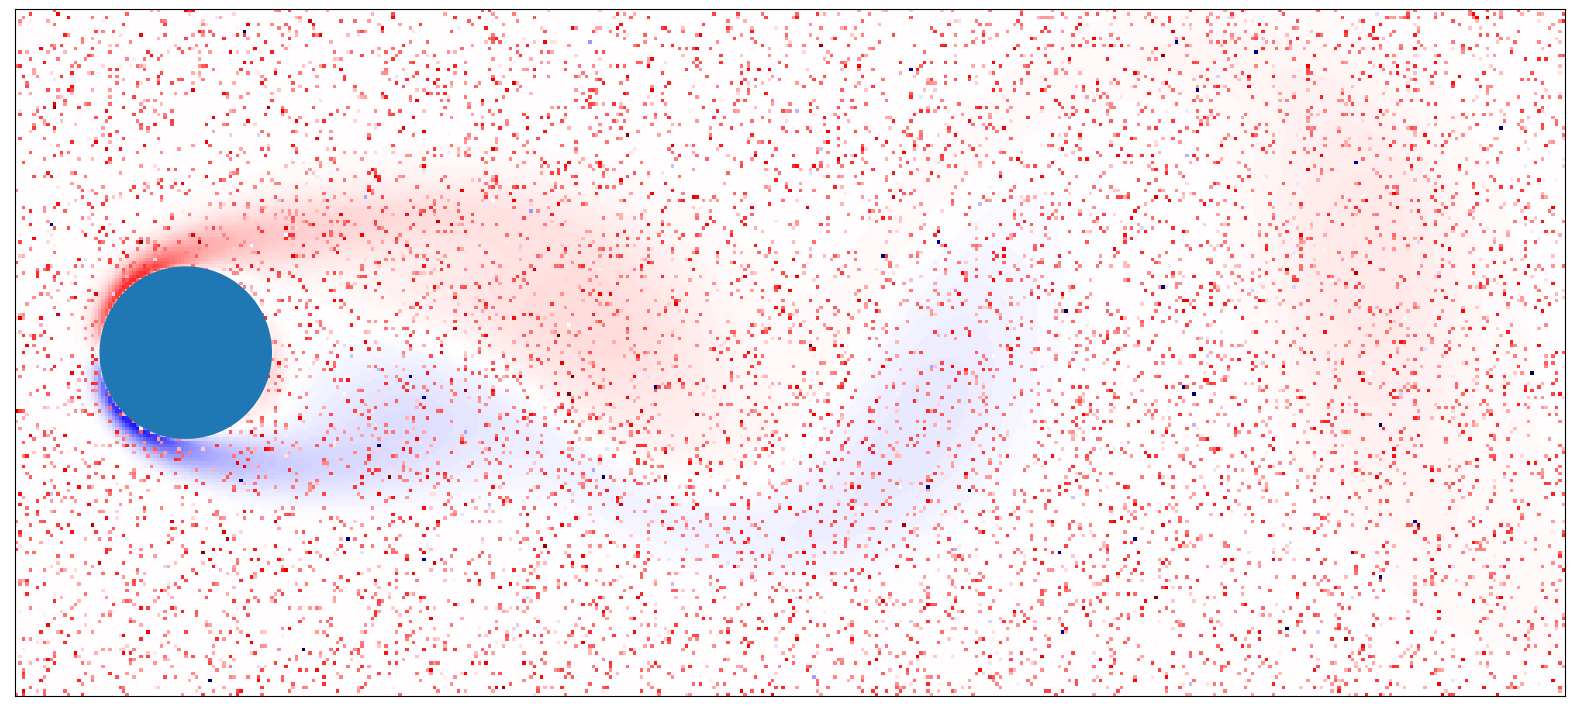

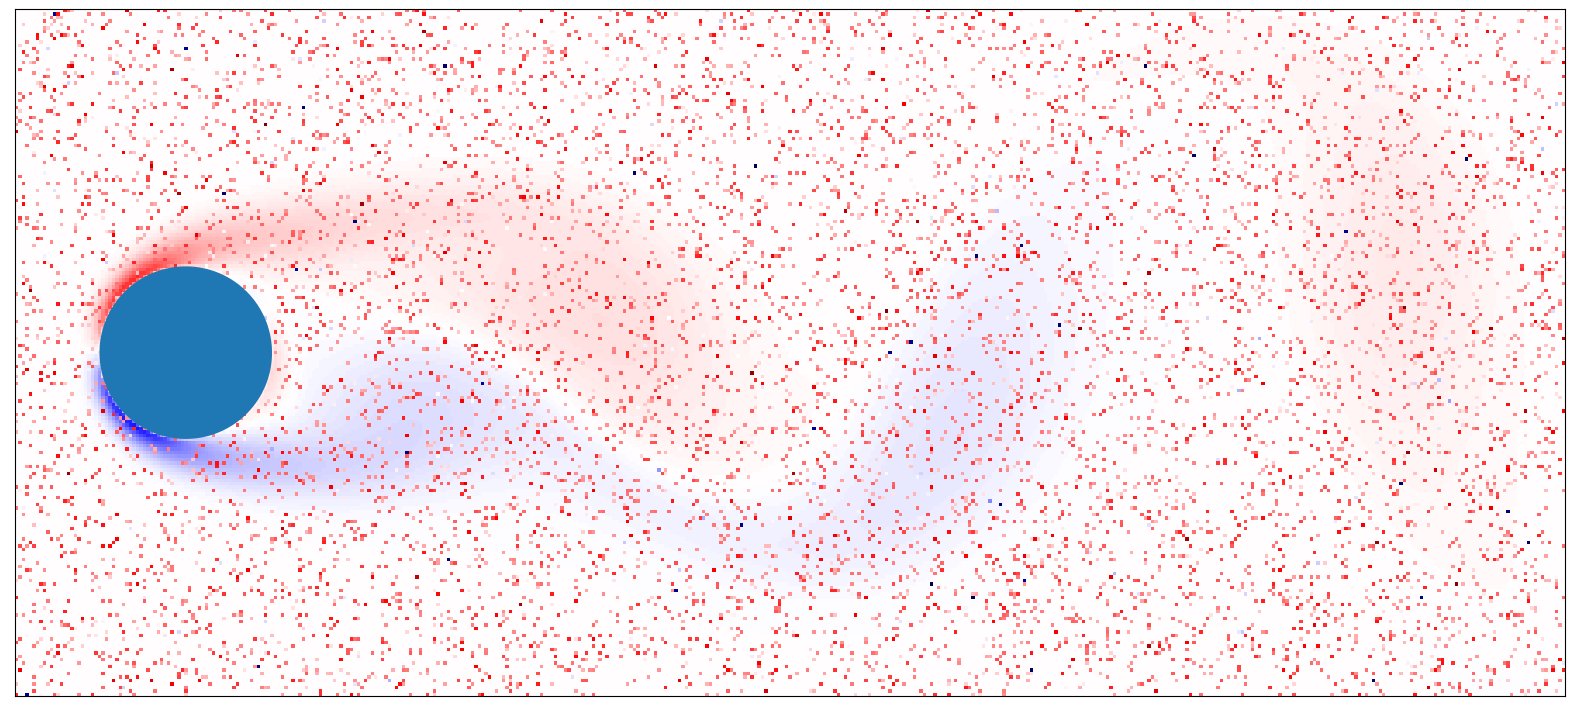

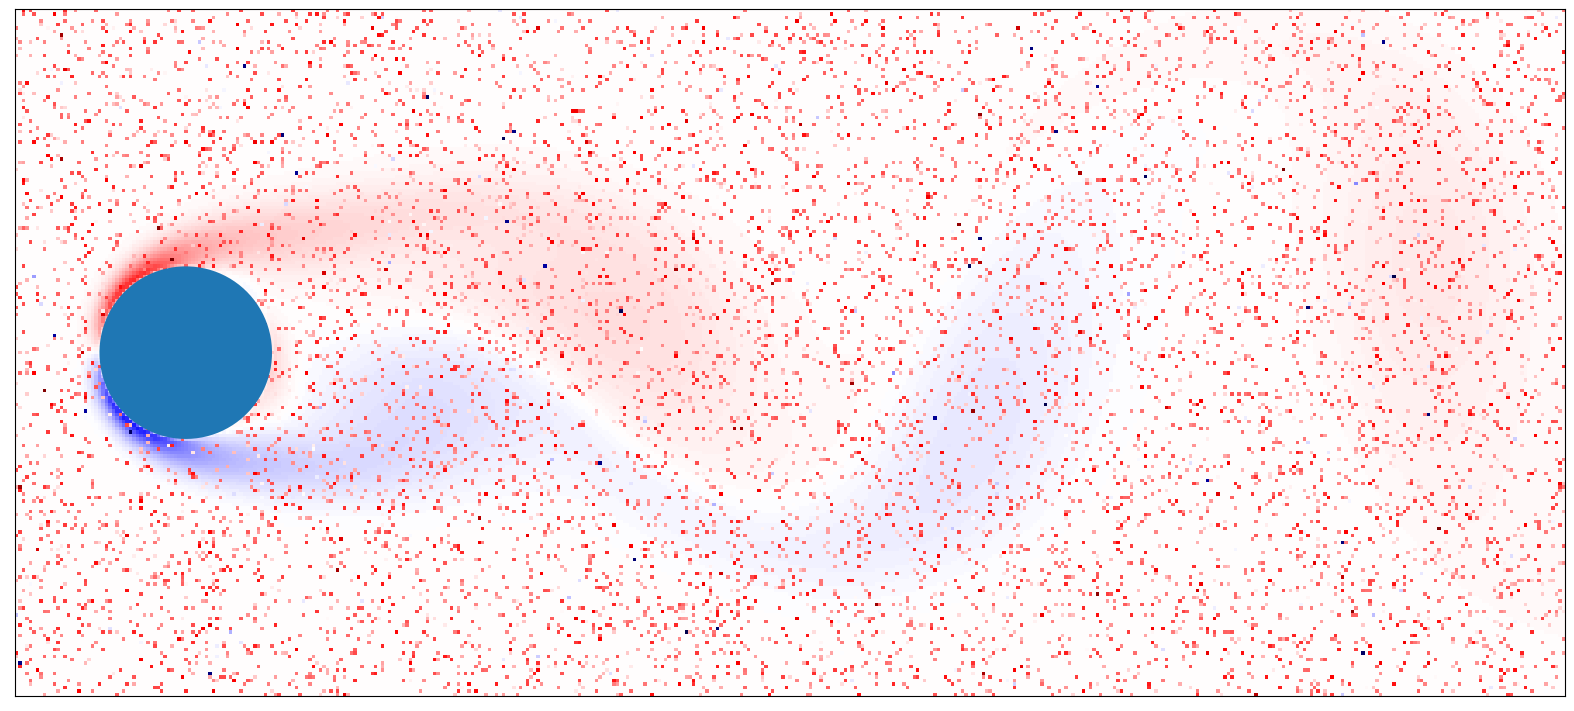

In [16]:
X_image = np.reshape(X,(ny,nx,151))
plot(X_image,3,'Image_measured')

-------------------------------------------------------
-------------------------------------------------------
-------------------------------------------------------

## $\color{blue}{\textbf{Mean centering}}$ 

### Choose centering method (mean-shifting):

**(a)** Centering concerning every single variable (pixel)
<br>
**(b)** Centering concerning all images


In [17]:
centering_a = False
centering_b = True

standardizing = False

#### (a) Centering concerning every single variable

In [18]:
if centering_a == True:
    X_mean = np.zeros(len(X))
    X_mean = np.mean(X, axis=0)
    X_preprocessed = (X - X_mean)
    # Calculate the mean and standard deviation of each feature
    
    if standardizing == True:
        X_preprocessed = X_preprocessed / np.std(X, axis=0)

#### (b) Centering concerning all images

In [19]:
if centering_b == True:
    X_preprocessed = np.zeros(X.shape)    
    X_mean = np.mean(X)
    X_preprocessed = (X - X_mean)

In [20]:
scaler = StandardScaler()
X_preprocessed = scaler.fit_transform(X)

-------------------------------------------------------
-------------------------------------------------------
-------------------------------------------------------

<span style="color:green; font-size:36px; font-weight:bold;">PCA</span>

In [21]:
X_clean[:,int(len(X[1])/2):].shape

(89351, 76)

In [22]:
# Robust PCAfrom sklearn.decomposition import PCA
pca = PCA(n_components = num_components)  # project from 64 to 2 dimensions
score=pca.fit_transform(X)
coeff=pca.components_ #eigen vectors.T
latent = pca.explained_variance_
explained = pca.explained_variance_ratio_
Phi = np.reshape(score,(ny,nx,num_components))

M_reconstructed = np.reshape(pca.inverse_transform(score),(ny,nx,151))

<span style="color:blue; font-size:26px; font-weight:bold;">PCA Modes</span>

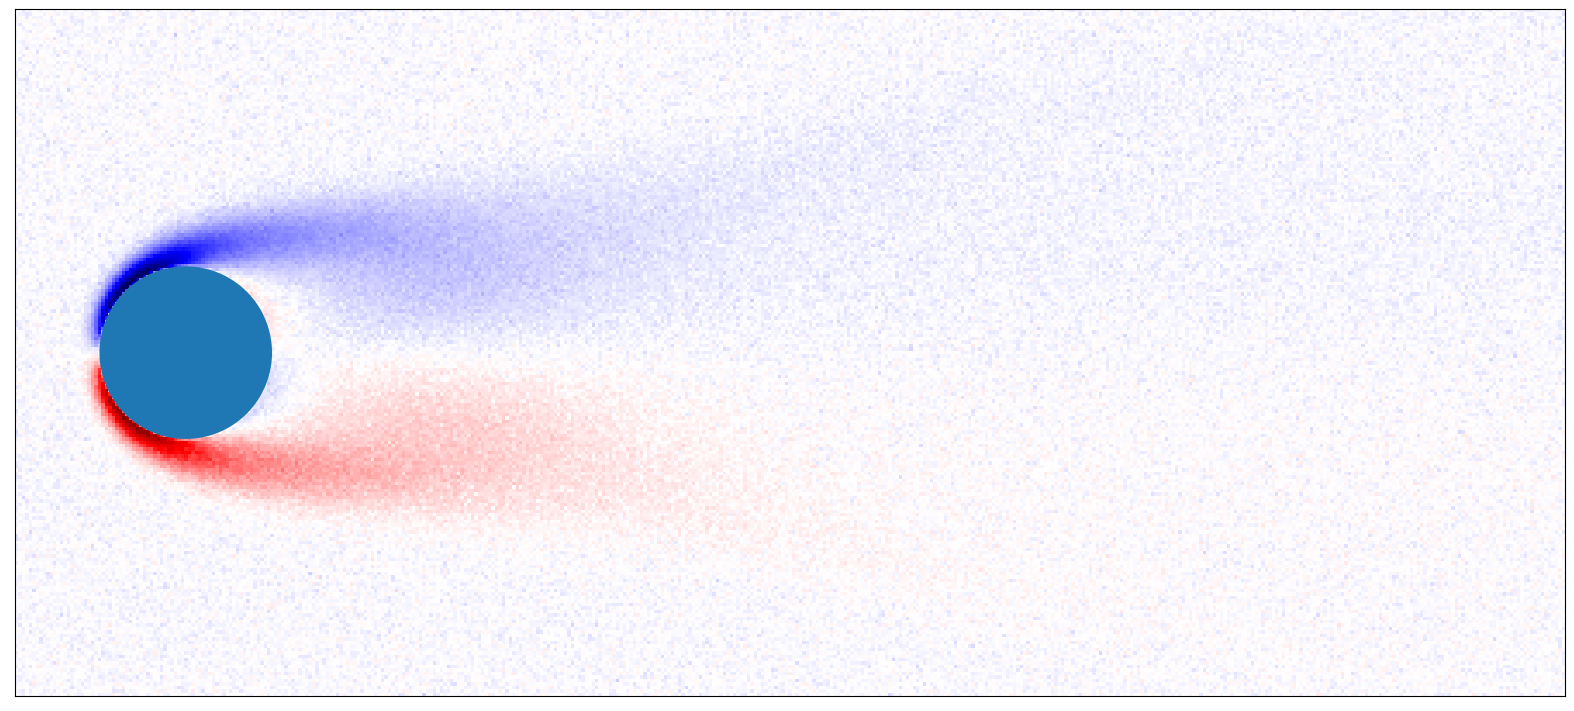

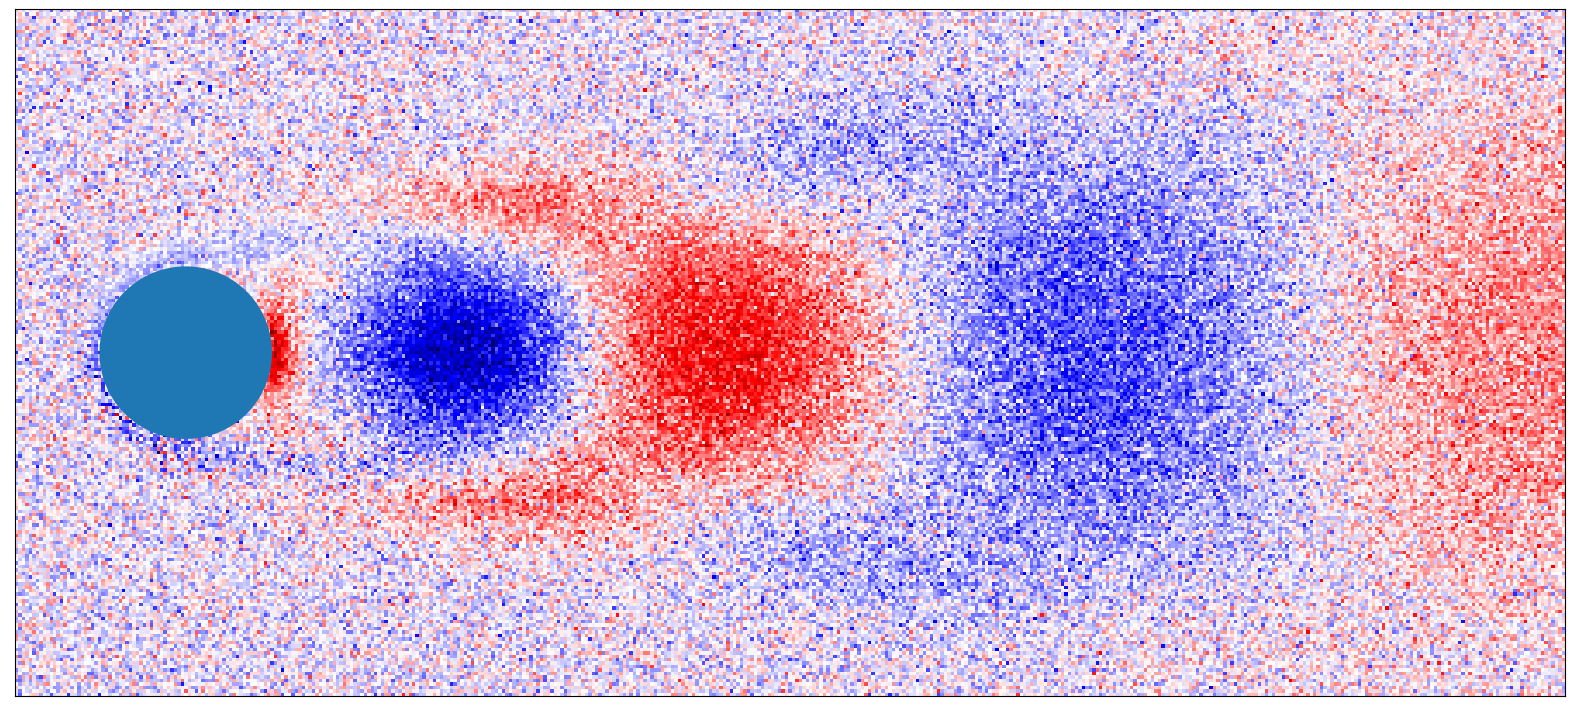

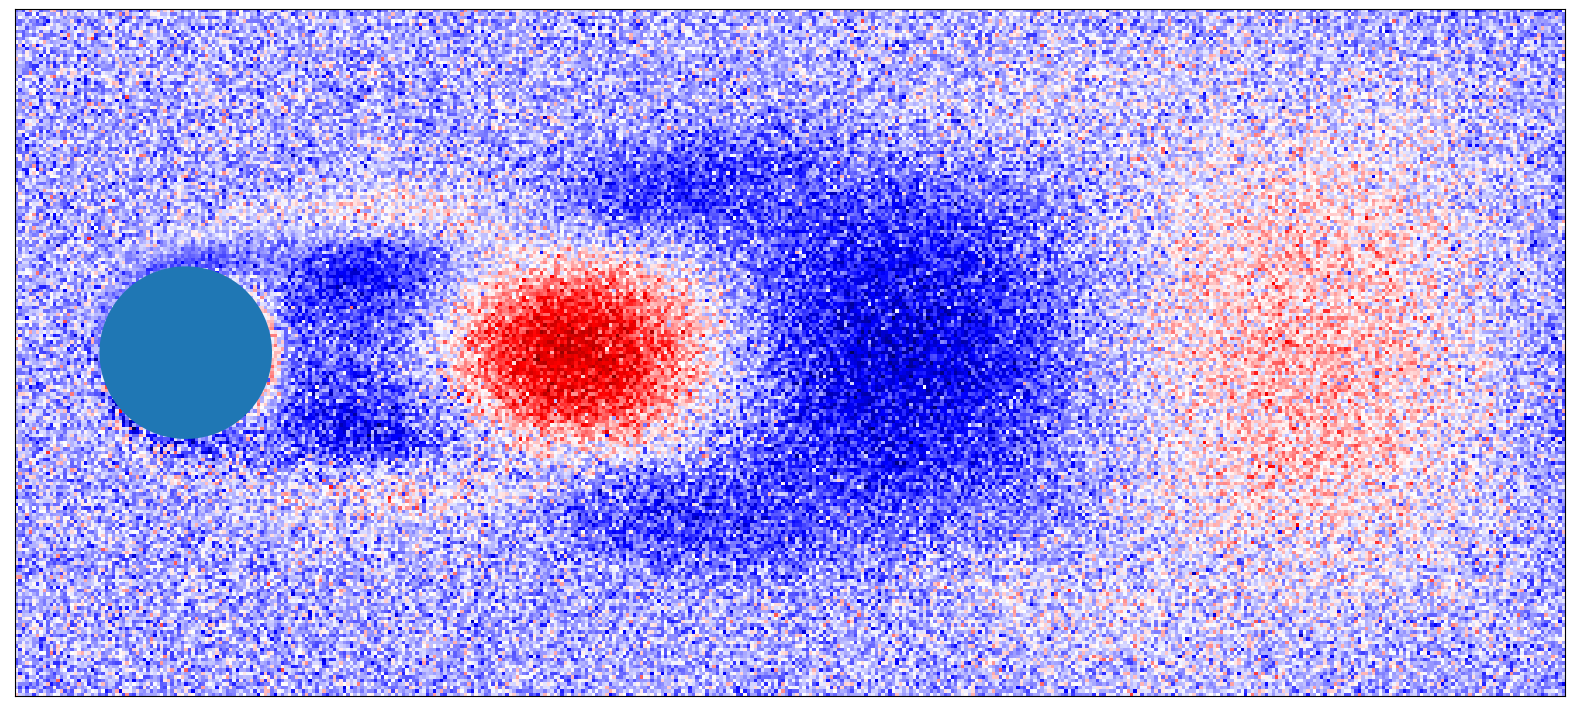

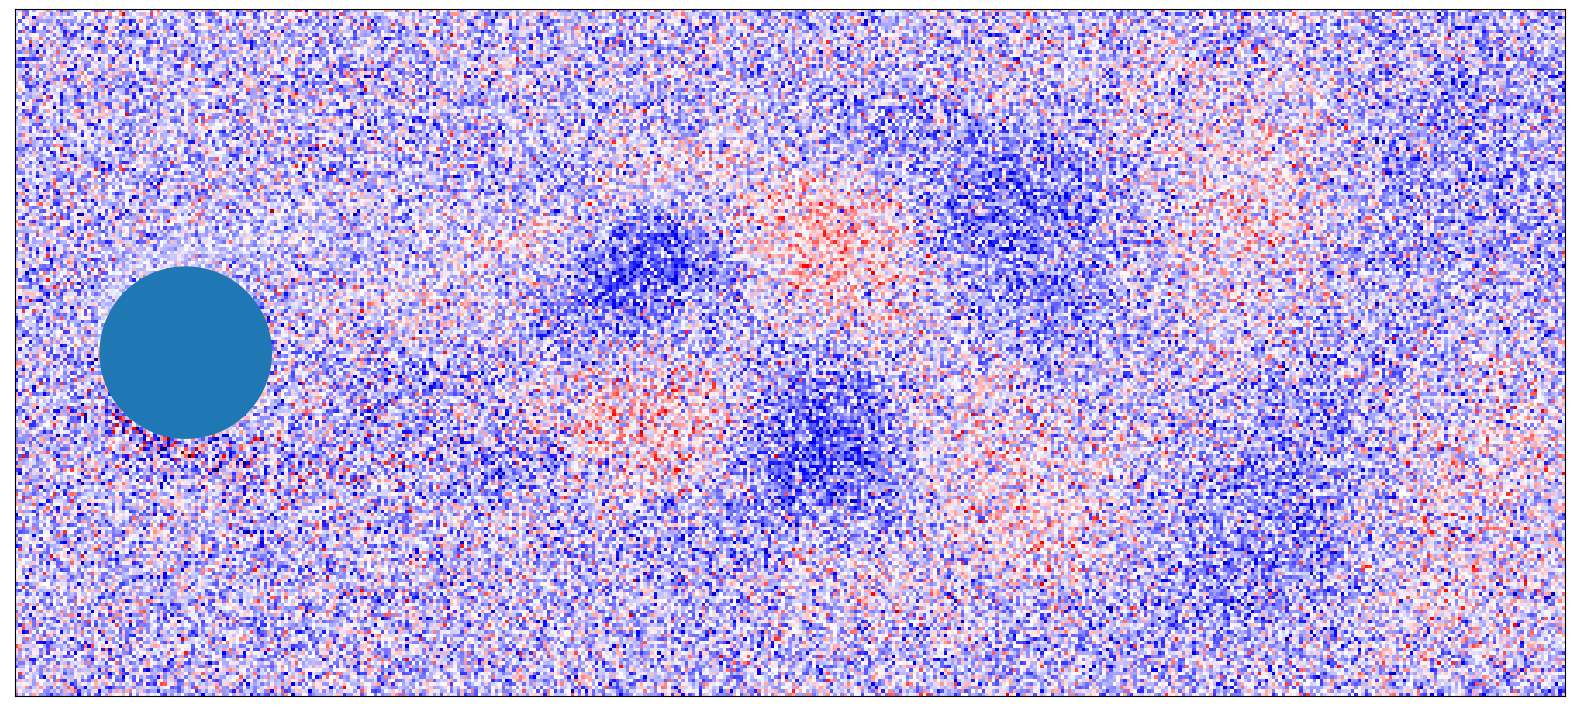

In [23]:
plot(Phi,4,'PCA_modes')

<span style="color:blue; font-size:26px; font-weight:bold;">PCA (Reconstructed Images)</span>

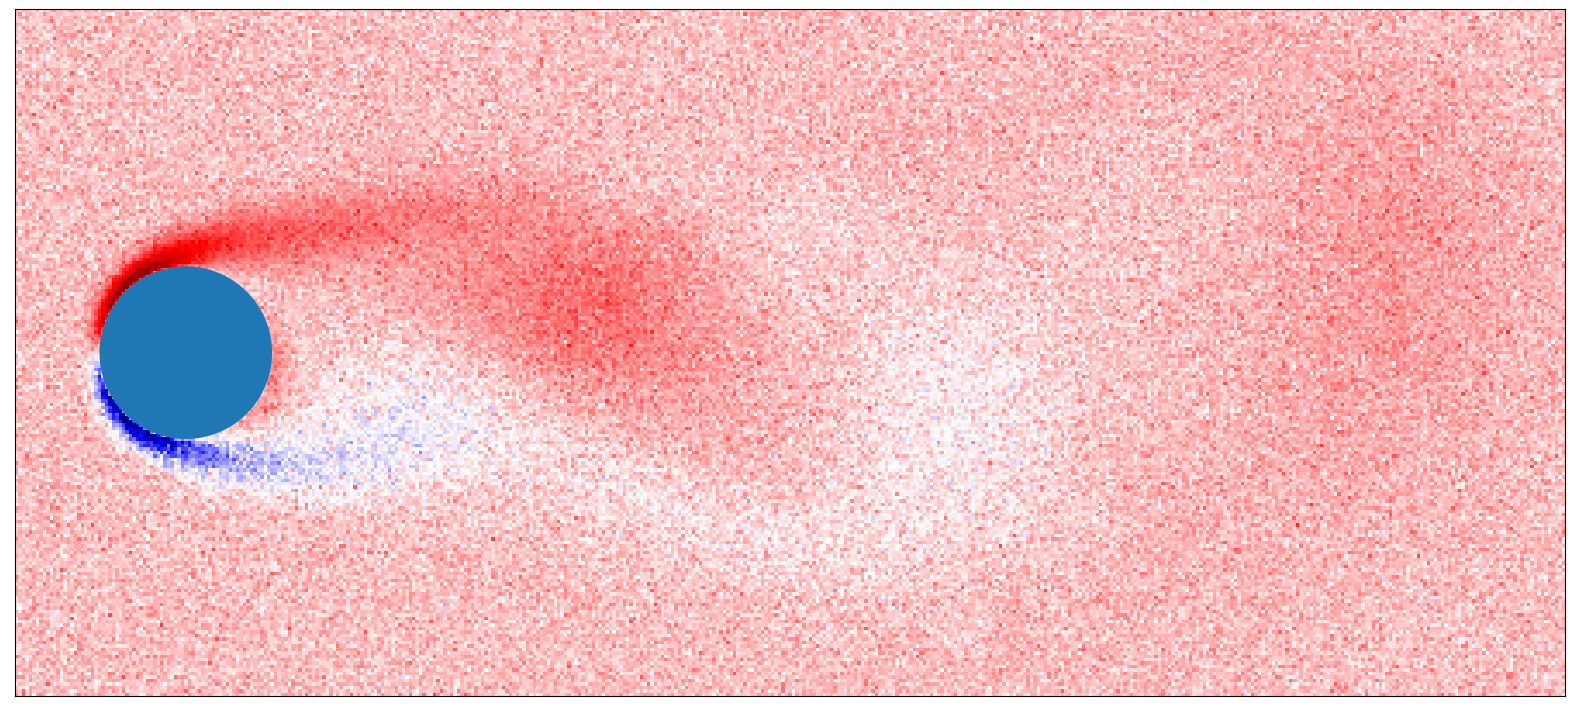

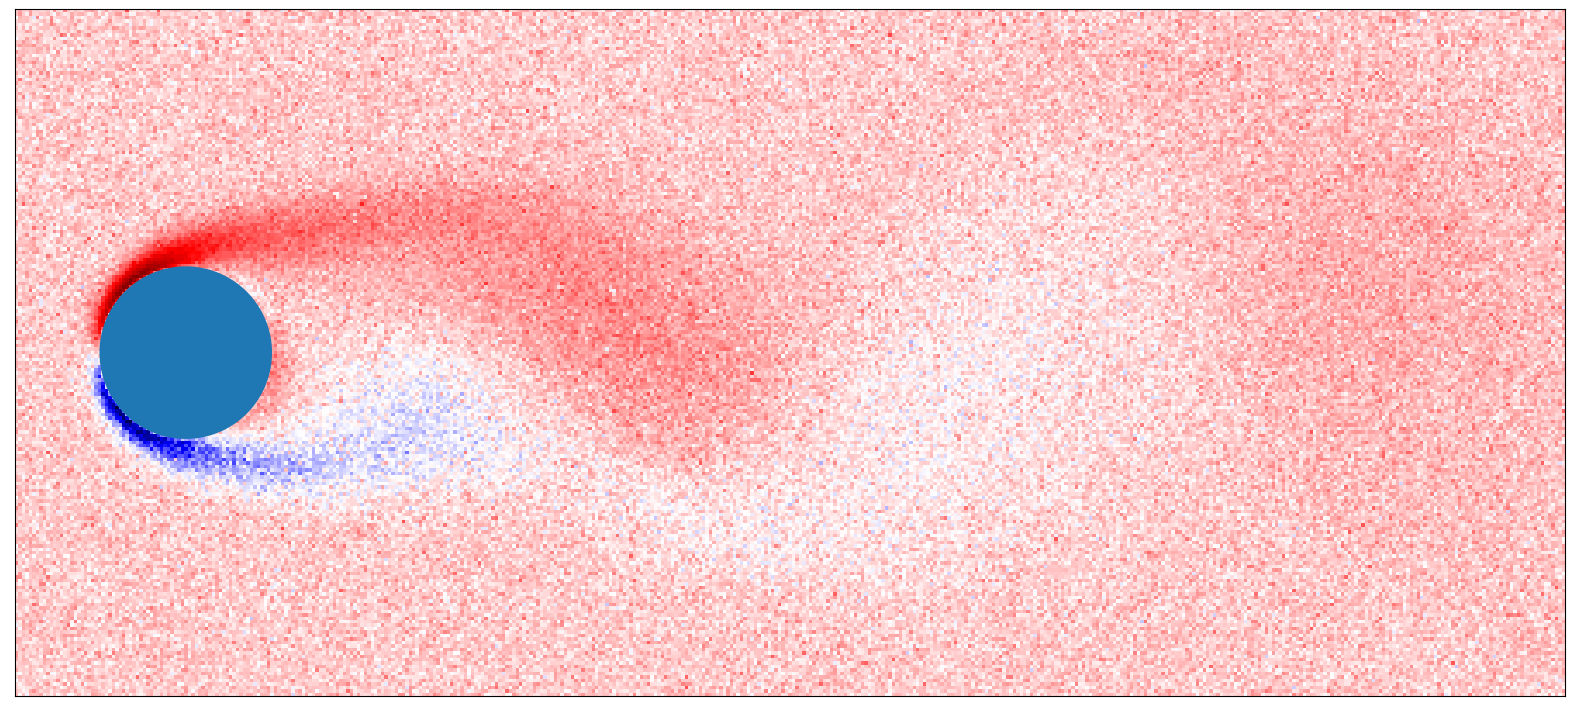

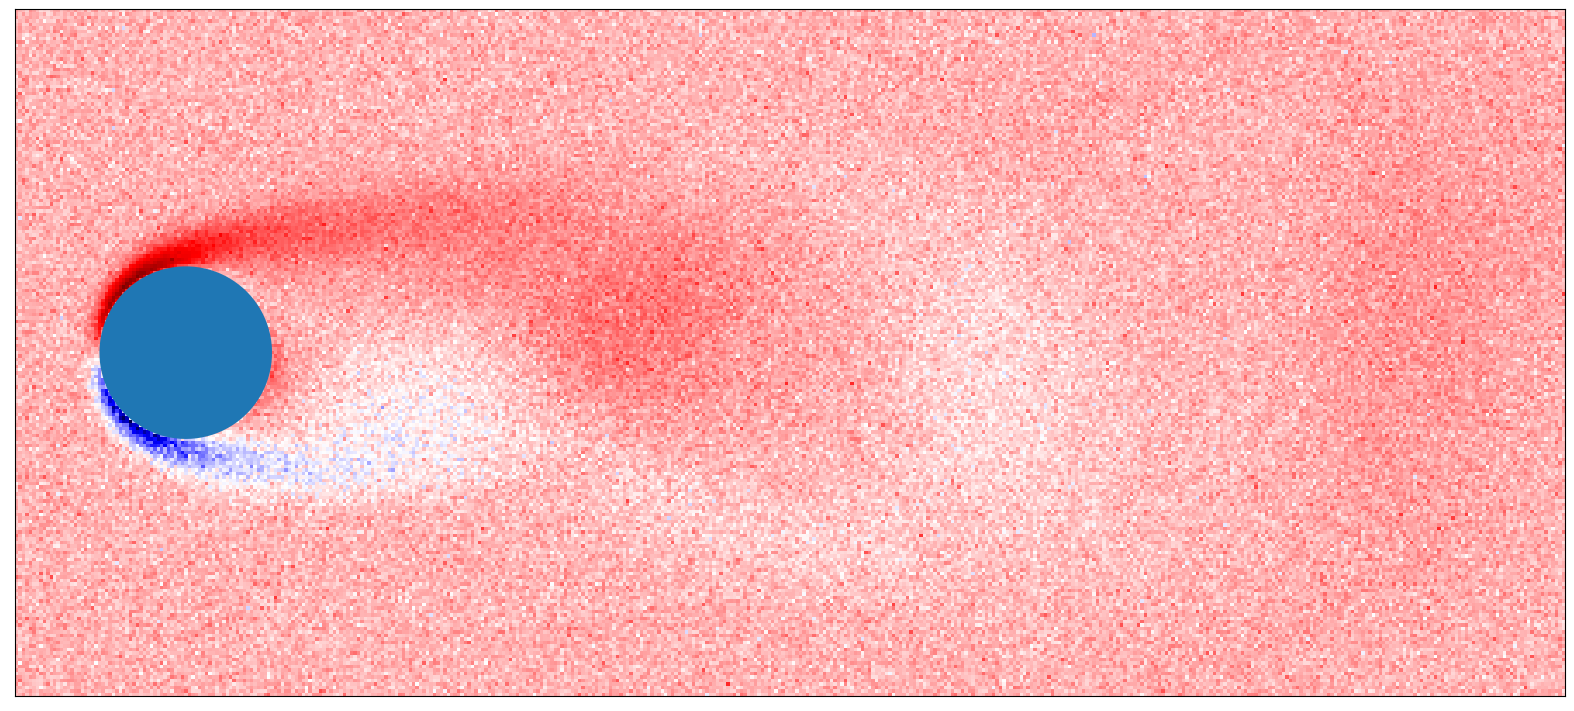

In [24]:
plot(M_reconstructed,3,'PCA_reconstructed')

-------------------------------------------------------
-------------------------------------------------------
-------------------------------------------------------

<span style="color:green; font-size:36px; font-weight:bold;">Robust PCA</span>

In [25]:
class RobustPCA:
    """
    Solves robust PCA using Inexact ALM as explained in Algorithm 5 of https://arxiv.org/pdf/1009.5055.pdf
    Parameters
    ----------
        lmb: 
            penalty on sparse errors
        mu_0: 
            initial lagrangian penalty
        rho: 
            learning rate
        tau:
            mu update criterion parameter
        max_iter:
            max number of iterations for the algorithm to run
        tol_rel:
            relative tolerance
        
    """
    def __init__(self, lmb: float, mu_0: float=1e-5, rho: float=2, tau: float=10, 
                 max_iter: int=20, tol_rel: float=1e-3):
        assert mu_0 > 0
        assert lmb > 0
        assert rho > 1
        assert tau > 1
        assert max_iter > 0
        assert tol_rel > 0
        self.mu_0_ = mu_0
        self.lmb_ = lmb
        self.rho_ = rho
        self.tau_ = tau
        self.max_iter_ = max_iter
        self.tol_rel_ = tol_rel
        
    def fit(self, X: np.ndarray):
        """
        Fits robust PCA to X and returns the low-rank and sparse components
        Parameters
        ----------
            X:
                Original data matrix

        Returns
        -------
            L:
                Low rank component of X
            S:
                Sparse error component of X
        """
        assert X.ndim == 2
        mu = self.mu_0_
        Y = X / self._J(X, mu)
        S = np.zeros_like(X)
        S_last = np.empty_like(S)
        for k in range(self.max_iter_):
            # Solve argmin_L ||X - (L + S) + Y/mu||_F^2 + (lmb/mu)*||L||_*
            L = svd_shrinkage(X - S + Y/mu, 1/mu)
            
            # Solve argmin_S ||X - (L + S) + Y/mu||_F^2 + (lmb/mu)*||S||_1
            S_last = S.copy()
            S = soft_thresholding(X - L + Y/mu, self.lmb_/mu)
            
            # Update dual variables Y <- Y + mu * (X - S - L)
            Y += mu*(X - S - L)
            r, h = self._get_residuals(X, S, L, S_last, mu)
            
            # Check stopping cirteria
            tol_r, tol_h = self._update_tols(X, L, S, Y)
            if r < tol_r and h < tol_h:
                break
                
            # Update mu
            mu = self._update_mu(mu, r, h)
            
        return L, S
            
    def _J(self, X: np.ndarray, lmb: float):
        """
        The function J() required for initialization of dual variables as advised in Section 3.1 of 
        https://people.eecs.berkeley.edu/~yima/matrix-rank/Files/rpca_algorithms.pdf            
        """
        return max(np.linalg.norm(X), np.max(np.abs(X))/lmb)
    
    @staticmethod
    def _get_residuals(X: np.ndarray, S: np.ndarray, L: np.ndarray, S_last: np.ndarray, mu: float):
        primal_residual = np.linalg.norm(X - S - L, ord="fro")
        dual_residual = mu*np.linalg.norm(S - S_last, ord="fro")
        return primal_residual, dual_residual
    
    def _update_mu(self, mu: float, r: float, h: float):
        if r > self.tau_ * h:
            return mu * self.rho_
        elif h > self.tau_ * r:
            return mu / self.rho_
        else:
            return mu
        
    def _update_tols(self, X, S, L, Y):
        tol_primal = self.tol_rel_ * max(np.linalg.norm(X), np.linalg.norm(S), np.linalg.norm(L))
        tol_dual = self.tol_rel_ * np.linalg.norm(Y)
        return tol_primal, tol_dual
    
def soft_thresholding(y: np.ndarray, mu: float):
    """
    Soft thresholding operator as explained in Section 6.5.2 of https://web.stanford.edu/~boyd/papers/pdf/prox_algs.pdf
    Solves the following problem:
    argmin_x (1/2)*||x-y||_F^2 + lmb*||x||_1

    Parameters
    ----------
        y : np.ndarray
            Target vector/matrix
        lmb : float
            Penalty parameter
    Returns
    -------
        x : np.ndarray
            argmin solution
    """
    return np.sign(y) * np.clip(np.abs(y) - mu, a_min=0, a_max=None)

def svd_shrinkage(y: np.ndarray, tau: float):
    """
    SVD shrinakge operator as explained in Theorem 2.1 of https://statweb.stanford.edu/~candes/papers/SVT.pdf
    Solves the following problem:
    argmin_x (1/2)*||x-y||_F^2 + tau*||x||_*
    
    Parameters
    ----------
        y : np.ndarray
            Target vector/matrix
        tau : float
            Penalty parameter
    Returns
    -------
        x : np.ndarray
            argmin solution
    
    """
    U, s, Vh = np.linalg.svd(y, full_matrices=False)
    s_t = soft_thresholding(s, tau)
    return U.dot(np.diag(s_t)).dot(Vh)

In [26]:
# Create an instance of the RobustPCA class
rpc = RobustPCA(lmb=0.006)

# Call the fit method with your data matrix X
L, S = rpc.fit(X)

# L is the low-rank matrix and S is the sparse matrix
print("Low-rank matrix L: ")
print(L)
print("Sparse matrix S: ")
print(S)

Low-rank matrix L: 
[[ 2.64299279e-04 -2.87831780e-04  1.87192712e-04 ...  1.90591520e-04
  -1.02417859e-04 -8.31674520e-05]
 [ 8.66379123e-05 -1.42139771e-04  7.66121963e-05 ...  1.37233495e-04
  -1.34865565e-04  4.96670611e-05]
 [ 2.54574655e-04 -1.57489454e-04  7.22876935e-05 ...  1.86838675e-04
  -5.71339402e-05 -1.02983240e-04]
 ...
 [-1.66464729e-02 -1.75879455e-02 -2.66645862e-02 ... -1.25565355e-01
  -6.69744430e-02 -3.30580327e-02]
 [-3.06475216e-02 -2.98786189e-02 -3.58698595e-02 ... -1.39634181e-01
  -8.19451803e-02 -4.75435078e-02]
 [-4.36701839e-02 -4.14707914e-02 -4.39015030e-02 ... -1.53142979e-01
  -9.65226791e-02 -6.20255351e-02]]
Sparse matrix S: 
[[-0.          0.          0.         ... -0.         -0.
  -0.        ]
 [-0.         -0.         -0.         ... -0.          0.
  -0.        ]
 [-0.         -0.          0.         ... -0.          0.
  -0.        ]
 ...
 [ 0.          0.         -0.         ... -0.         12.89093322
  -0.        ]
 [-0.         -0.    

------------------------------------------------

<span style="color:blue; font-size:26px; font-weight:bold;">RPCA (Cleaned Images)</span>

## Low-rank matrix L   

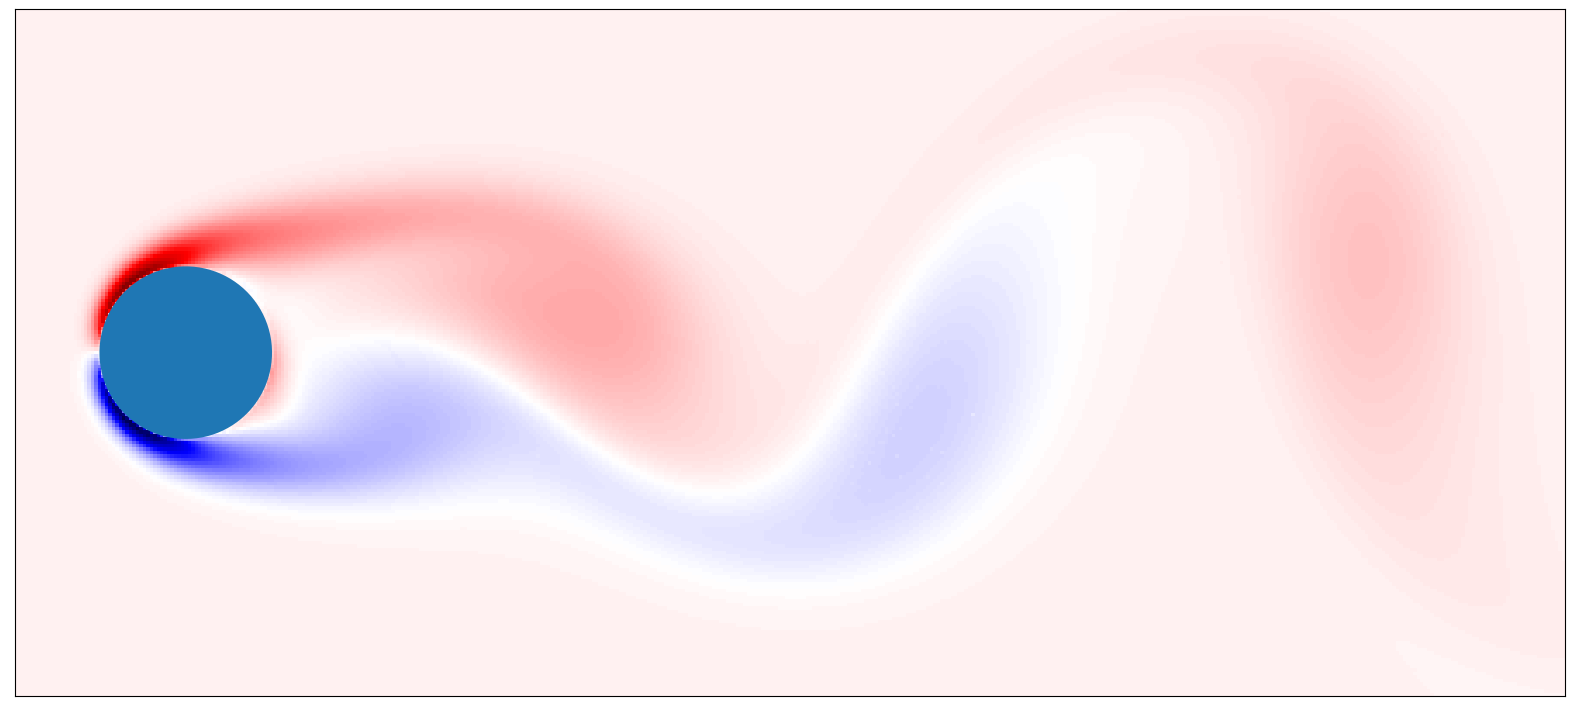

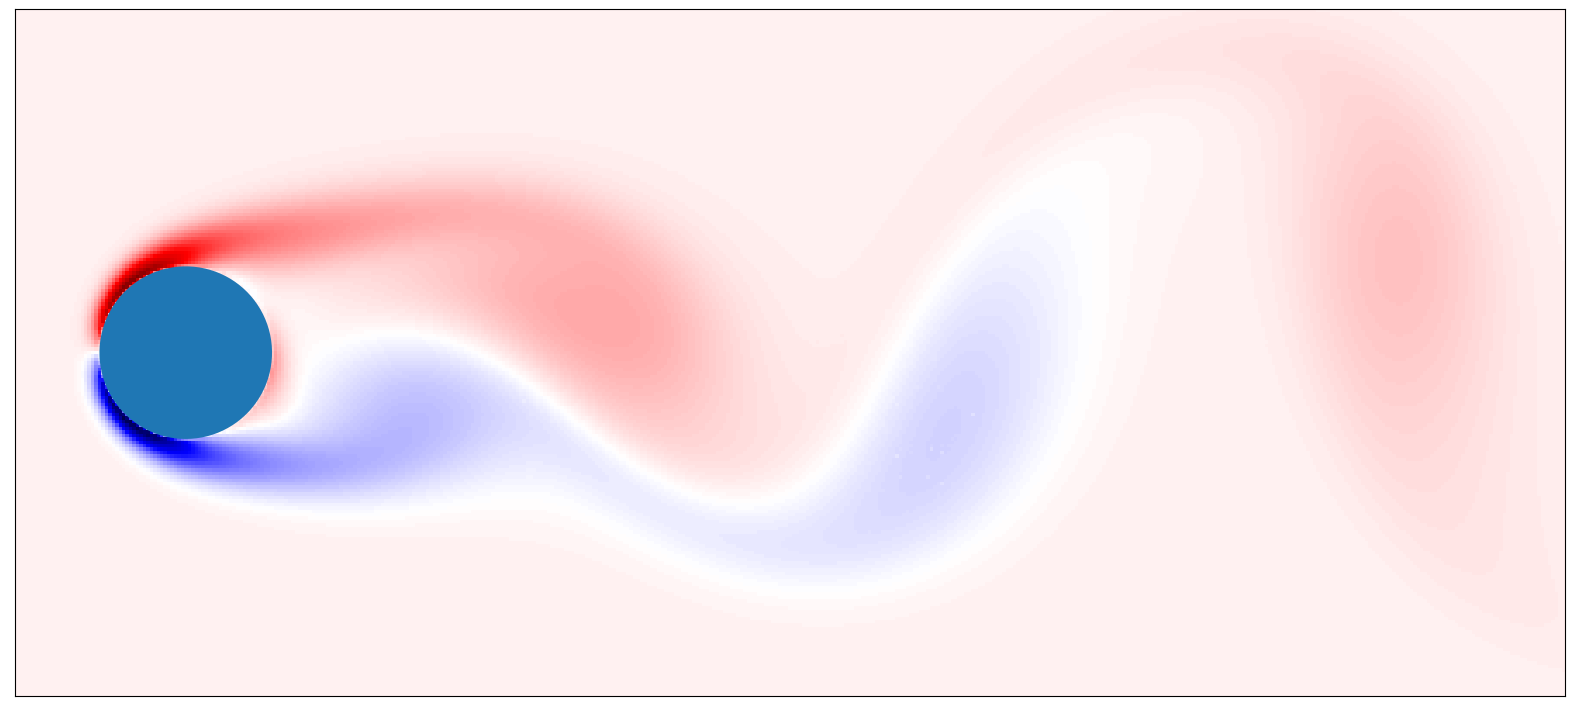

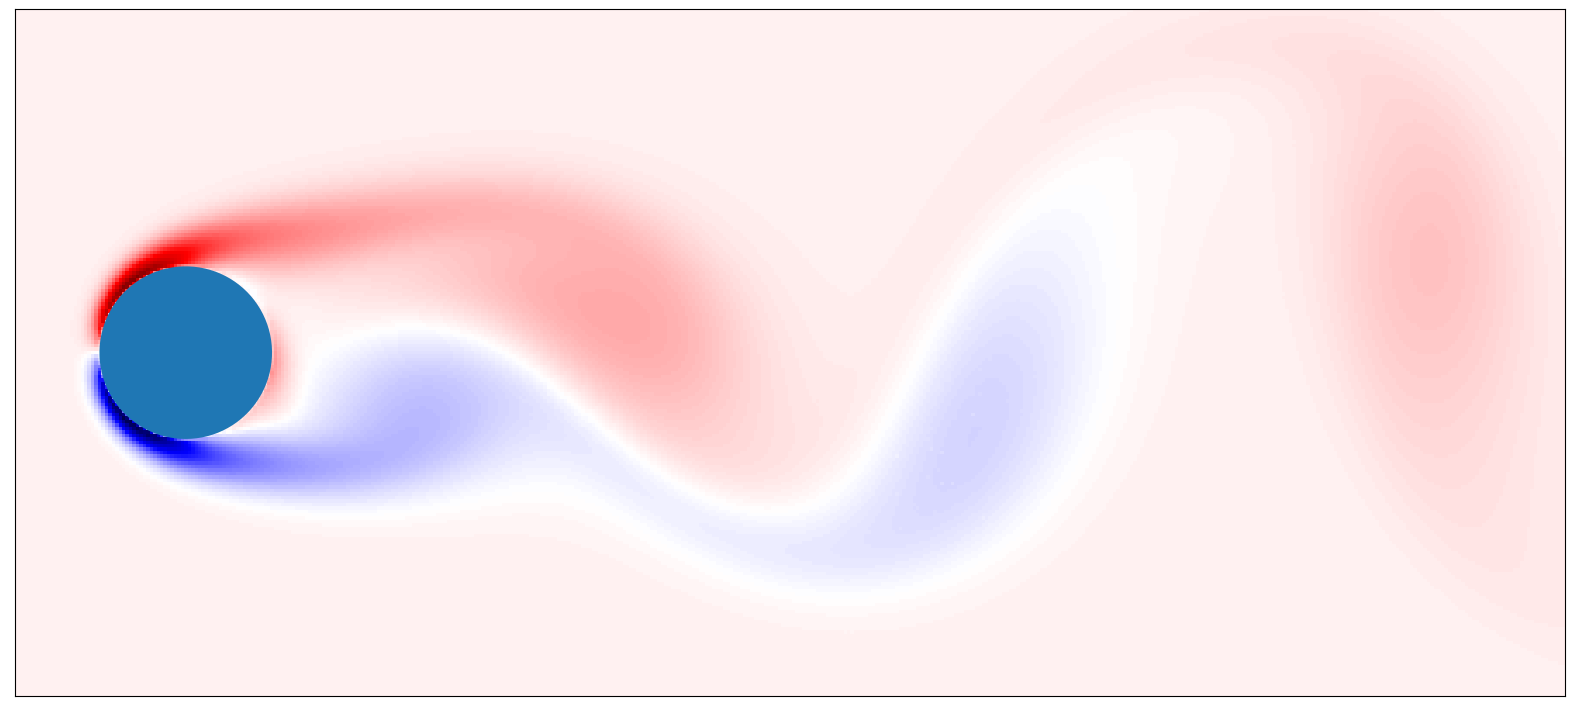

In [27]:
L_image = np.reshape(L,(ny,nx,151))
plot(L_image,3,'RPCA_L')

------------------------------------------------

<span style="color:blue; font-size:26px; font-weight:bold;">RPCA (Anomalies)</span>

## Sparse matrix S   

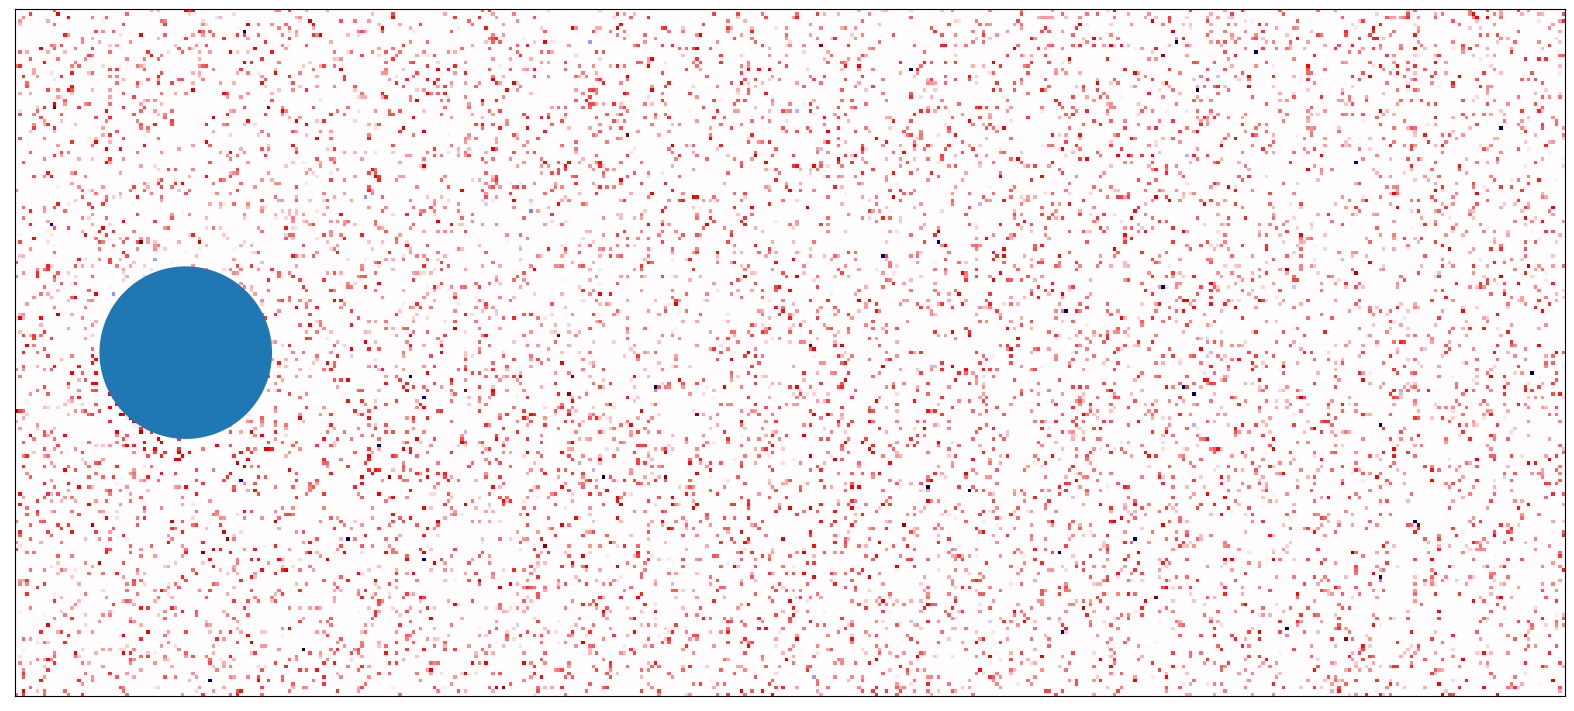

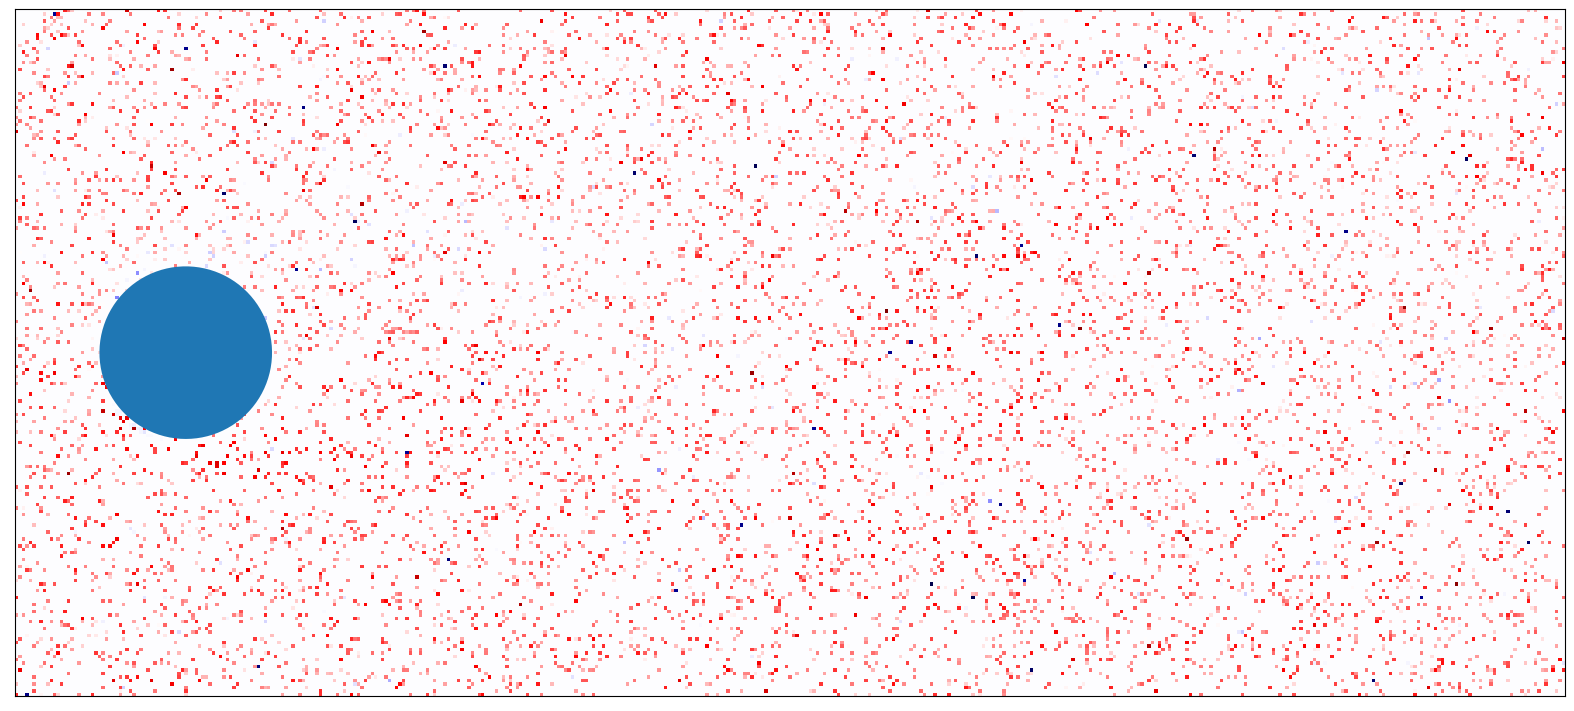

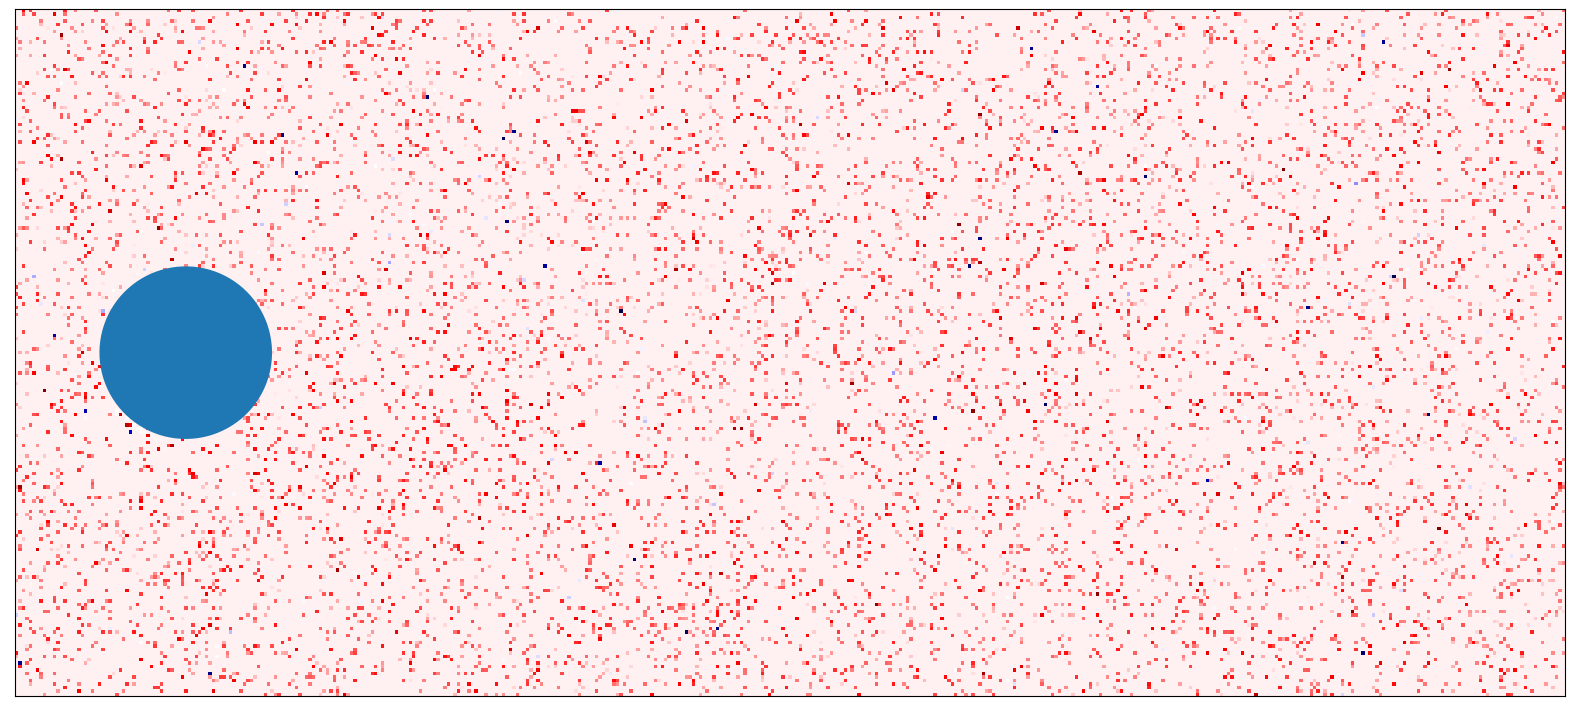

In [28]:
S_image = np.reshape(S,(ny,nx,151))
plot(S_image,3,'RPCA_S')

------------------------------------------------

<span style="color:blue; font-size:26px; font-weight:bold;">RPCA (Modes)</span>

## Modes of matrix L   

In [29]:
## Sparse matrix S   # Robust PCAfrom sklearn.decomposition import PCA
pca = PCA(n_components = num_components)  # project from 64 to 2 dimensions
score=pca.fit_transform(L)
coeff=pca.components_ #eigen vectors.T
latent = pca.explained_variance_
explained = pca.explained_variance_ratio_
Phi_L = np.reshape(score,(ny,nx,num_components))

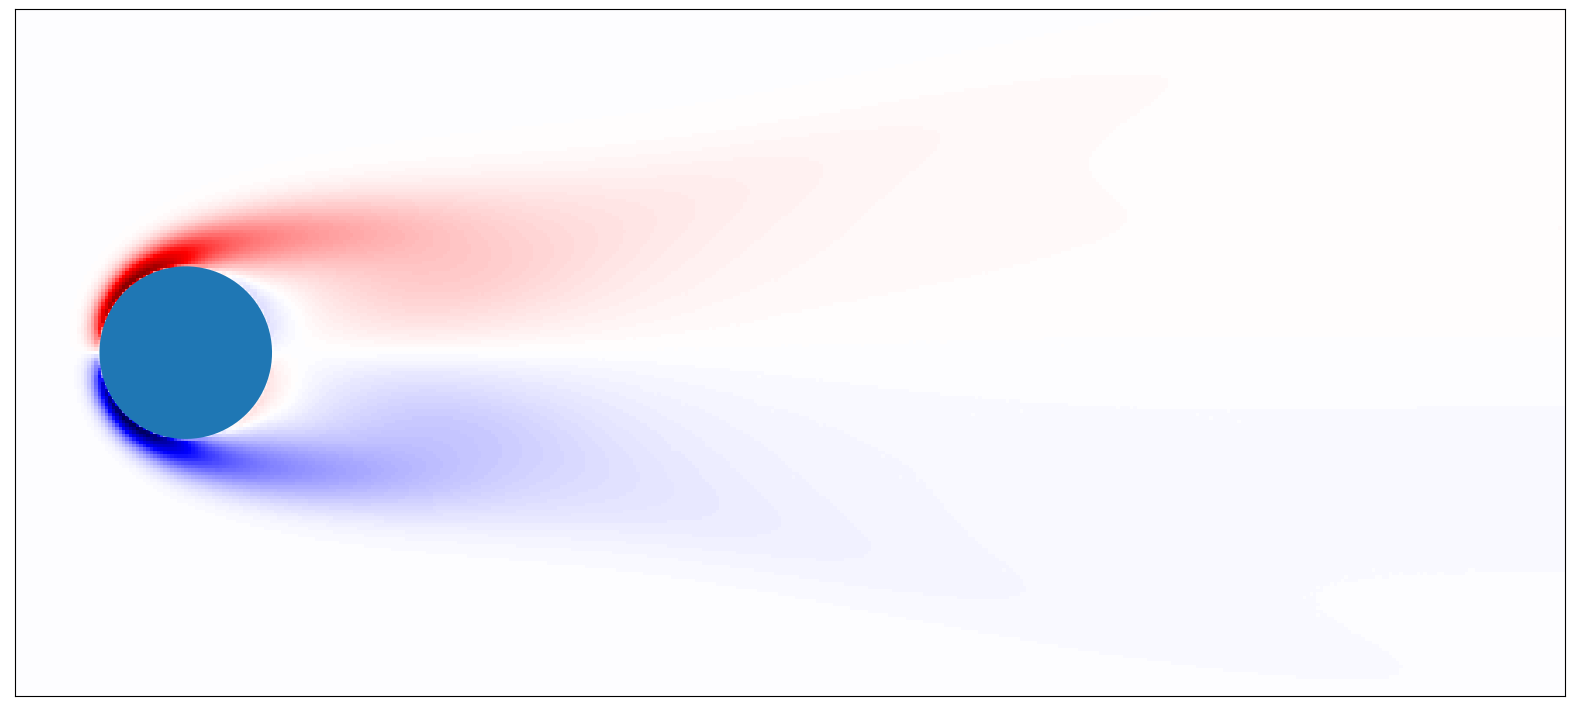

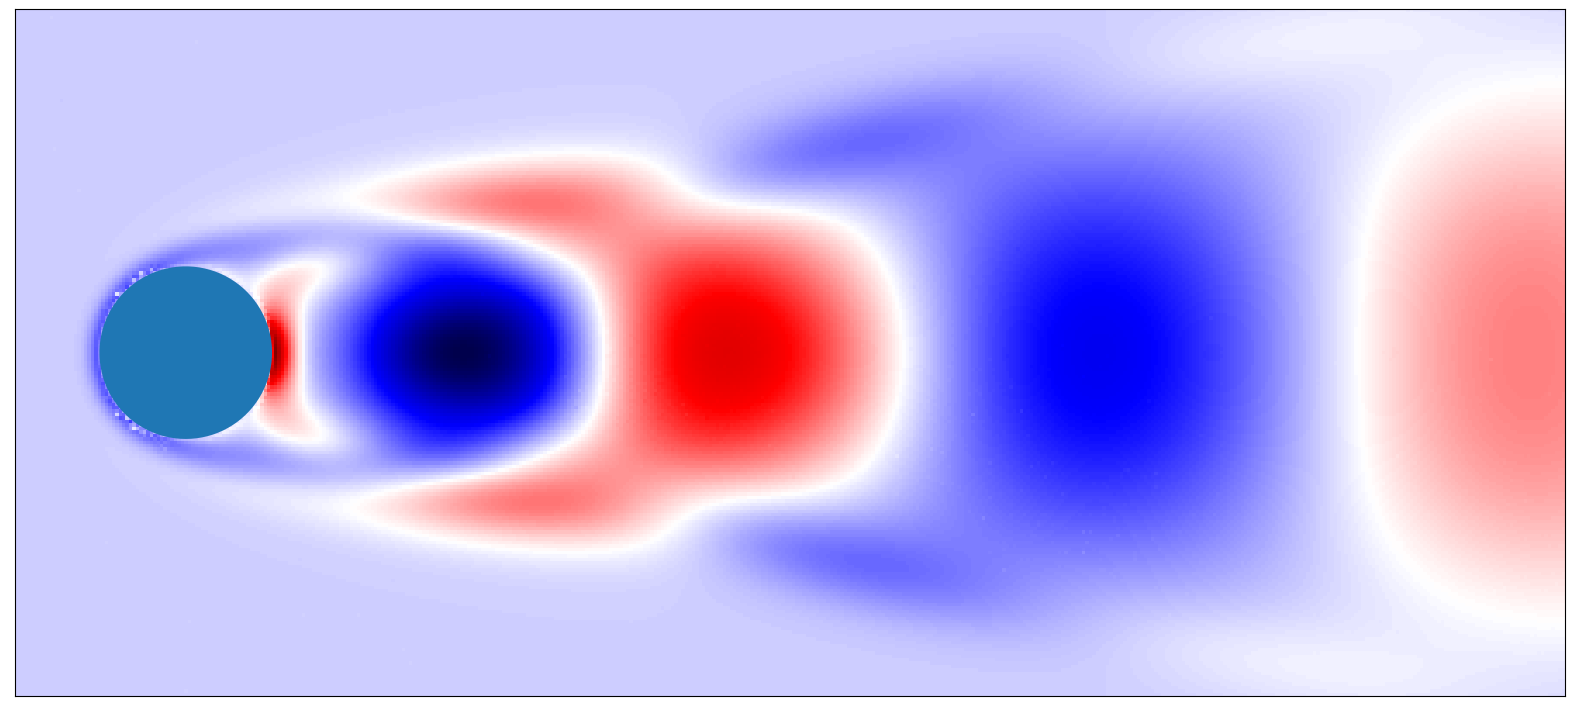

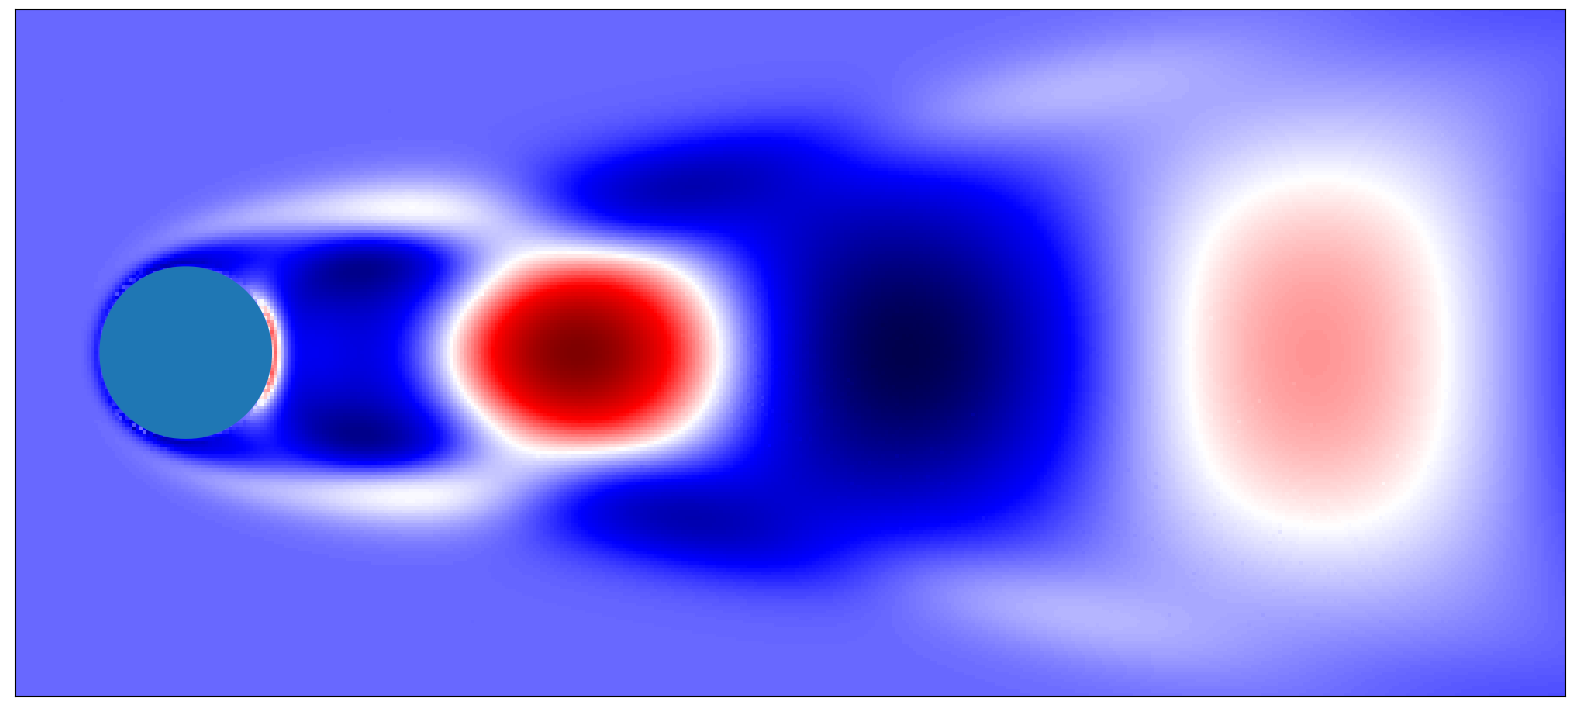

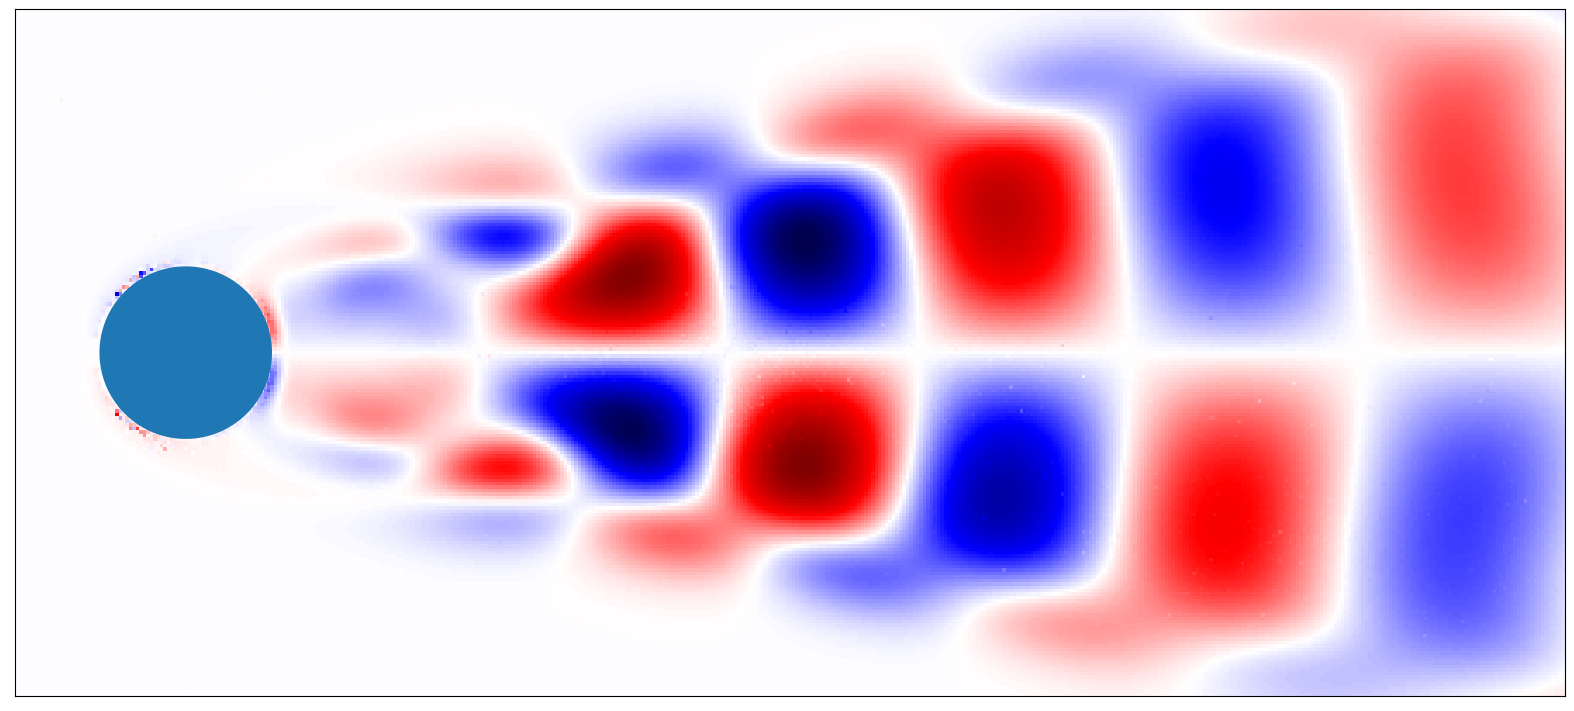

In [30]:
plot(Phi_L,4,'RPCA_modes')

-------------------------------------------------------
-------------------------------------------------------
-------------------------------------------------------

<span style="color:green; font-size:38px; font-weight:bold;">Optimal Sensor Placement</span>


### The OPS is now applied on the cleaned data (low-ranked matrix $L$)

## $\color{blue}{\textbf{Proper Orthogonal Decomposition (POD)}}$ 

If $X$ is the full data, the POD modes $\Psi_r$ are obtained a a SVD decomposed by: $X \approx \Psi_r S_r V_r^T$.

In [31]:
# number of POD components
n_POD_components = 10

In [32]:
# Function for finding first n POD components using svd
def calculate_POD(X, n):
    U, S, V = np.linalg.svd(X)
    S_r = S[:n]
    Psi_r = U[:,:n]
       
    return Psi_r, U, S, V

----------------------------------------------

#### If you want to apply OSP on the original data instead of on the cleaned matrix $L$, you need to convert the line below to code

----------------------------------------------

Note that the first 10 samples are ignored for training, to use them for showing the reconstruction capabilities

In [33]:
OSP_training_data = L[:,10:]

# Create an SVD object
svd = TruncatedSVD(n_components=n_POD_components)

# Fit the model to your data
# Ignoring the first 10 samples, to demonstrate real reconstruction capabilities
svd.fit(OSP_training_data)

# After fitting the model, you can access the V (component) matrix directly.
V = svd.components_

# The Sigma (singular values) matrix is available as singular_values_. It's a 1D array, not a full diagonal matrix.
Sigma = svd.singular_values_

# U matrix can't be directly computed from sklearn's TruncatedSVD. You need to do a matrix multiplication:
U = svd.transform(OSP_training_data)

# Divide every row of U by the singular values to obtain the actual U.
U = U / svd.singular_values_
Psi_r = U # POD modes

## $\color{blue}{\textbf{Optimal Sensor Placement Algorithm}}$ 

If $x$ is a single data point, it can be decomposed using the basis of the full data set: $x \approx \Psi_r a$

$y = C x$

$y \approx C \Psi_r a = \Theta a$

$\hat a = \Theta^{\dagger} y$ 

Using the estimate of $\hat a$, we can find an estimate of $\hat x$ using $\Psi_r$

$\hat x = \Psi_r \hat a = \Psi_r (C \Psi_r)^{\dagger} y = \Psi_r (C \Psi_r)^{\dagger} C x$

All one needs now to find a way to reconstruct data from sparse measurements is to find a good decomposition of the data $\Psi_r$ and a good sensor placement $C$. The optimal sensor locations $C$ can be identified by applying QR factorization with column pivoting on the POD modes $\Psi_r$.

In [34]:
# Number of sensors
# Number of sensors has to be larger or equal to the number of POD components
n_sensors = 10

In [35]:
import scipy.linalg

# Functions for finding optimal sensor placement 
def qr_pivots(Psi_r, num_eigen, num_sensors=None):
    if num_sensors is None:
        num_sensors = num_eigen
    
    M = Psi_r.T
    if num_sensors > num_eigen:
        M = Psi_r @  Psi_r.T

    Q, R, P = scipy.linalg.qr(M, pivoting=True)
    return P

def find_sensor_placement(Psi_r, num_eigen, num_sensors=None):
    P = qr_pivots(Psi_r, num_eigen, num_sensors)
    C = np.zeros((num_sensors,Psi_r.shape[0]))
    C[np.arange(num_sensors),P[:num_sensors]] = 1
    return C

In [36]:
# Finding the sensor placement matrix C
C = find_sensor_placement(Psi_r, n_POD_components, n_sensors)

C.shape

(10, 89351)

In [37]:
C_rot = np.reshape(C,(ny,nx,n_sensors))
C_rot = np.sum(C_rot, axis=2)

## $\color{blue}{\textbf{Plot of the optimal sensor positions}}$ 

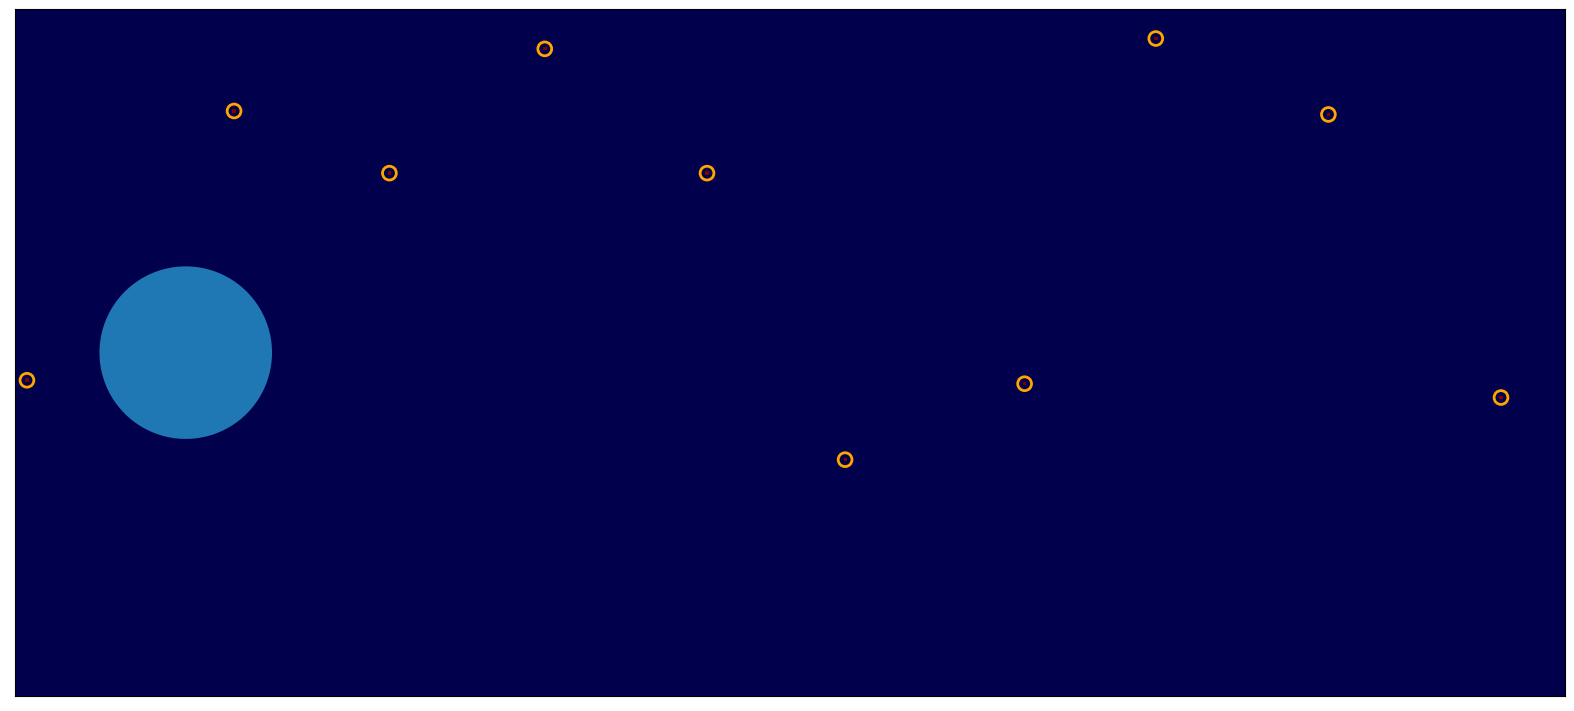

In [38]:
C_indices = np.array(np.nonzero(C_rot)).T

plt.figure(figsize = (20,30))

circle1 = plt.Circle(C_indices[0,:], 2, linewidth=2, color='orange', fill=False)
circle2 = plt.Circle(C_indices[1,:], 2, linewidth=2, color='orange', fill=False)
circle3 = plt.Circle(C_indices[2,:], 2, linewidth=2, color='orange', fill=False)
circle4 = plt.Circle(C_indices[3,:], 2, linewidth=2, color='orange', fill=False)
circle5 = plt.Circle(C_indices[4,:], 2, linewidth=2, color='orange', fill=False)
circle6 = plt.Circle(C_indices[5,:], 2, linewidth=2, color='orange', fill=False)
circle7 = plt.Circle(C_indices[6,:], 2, linewidth=2, color='orange', fill=False)
circle8 = plt.Circle(C_indices[7,:], 2, linewidth=2, color='orange', fill=False)
circle9 = plt.Circle(C_indices[8,:], 2, linewidth=2, color='orange', fill=False)
circle10 = plt.Circle(C_indices[9,:], 2, linewidth=2, color='orange', fill=False)

plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)
plt.gca().add_patch(circle3)
plt.gca().add_patch(circle4)
plt.gca().add_patch(circle5)
plt.gca().add_patch(circle6)
plt.gca().add_patch(circle7)
plt.gca().add_patch(circle8)
plt.gca().add_patch(circle9)
plt.gca().add_patch(circle10)


theta = np.linspace(0,1,100)
theta = theta * 2*22.0/7.
x = 49.0+25.0*np.sin(theta)
y = 99.0+25.0*np.cos(theta)

plt.imshow(np.real(C_rot[:,:].T),cmap='seismic')
plt.fill(x,y)
# Compute the maximum absolute value in the data
#clim = max(abs(s.min()), s.max())
#clim = max(-40, 40)
# Set the color limits to extend the same amount in both directions from zero
#im.set_clim(-clim, clim)
#plt.colorbar(im)
        
#plt.axis('off')
plt.xticks([])  # Remove x-axis labels
plt.yticks([])  # Remove y-axis labels
filename = './fig/'+'OSP'+'.pdf'
plt.savefig(filename,bbox_inches="tight")      
plt.show()          

### Image Reconstruction

In [39]:
Theta = C @ Psi_r
Theta_inv = np.linalg.pinv(Theta)

In [40]:
Y = np.dot(C, L)

In [41]:
def reconstruct_from_measurements(Y, C, Psi_r, X_mean, Theta_inv = None):
    if Theta_inv is None:
        Theta_inv = np.linalg.inv(np.dot(C, Psi_r))
    X_hat = np.dot(Psi_r, np.dot(Theta_inv, Y)).T + X_mean
    return X_hat

In [42]:
X_hat = reconstruct_from_measurements(Y, C, Psi_r, 0, Theta_inv)

<span style="color:blue; font-size:26px; font-weight:bold;">OSP reconstructed images from 10 measurements</span>

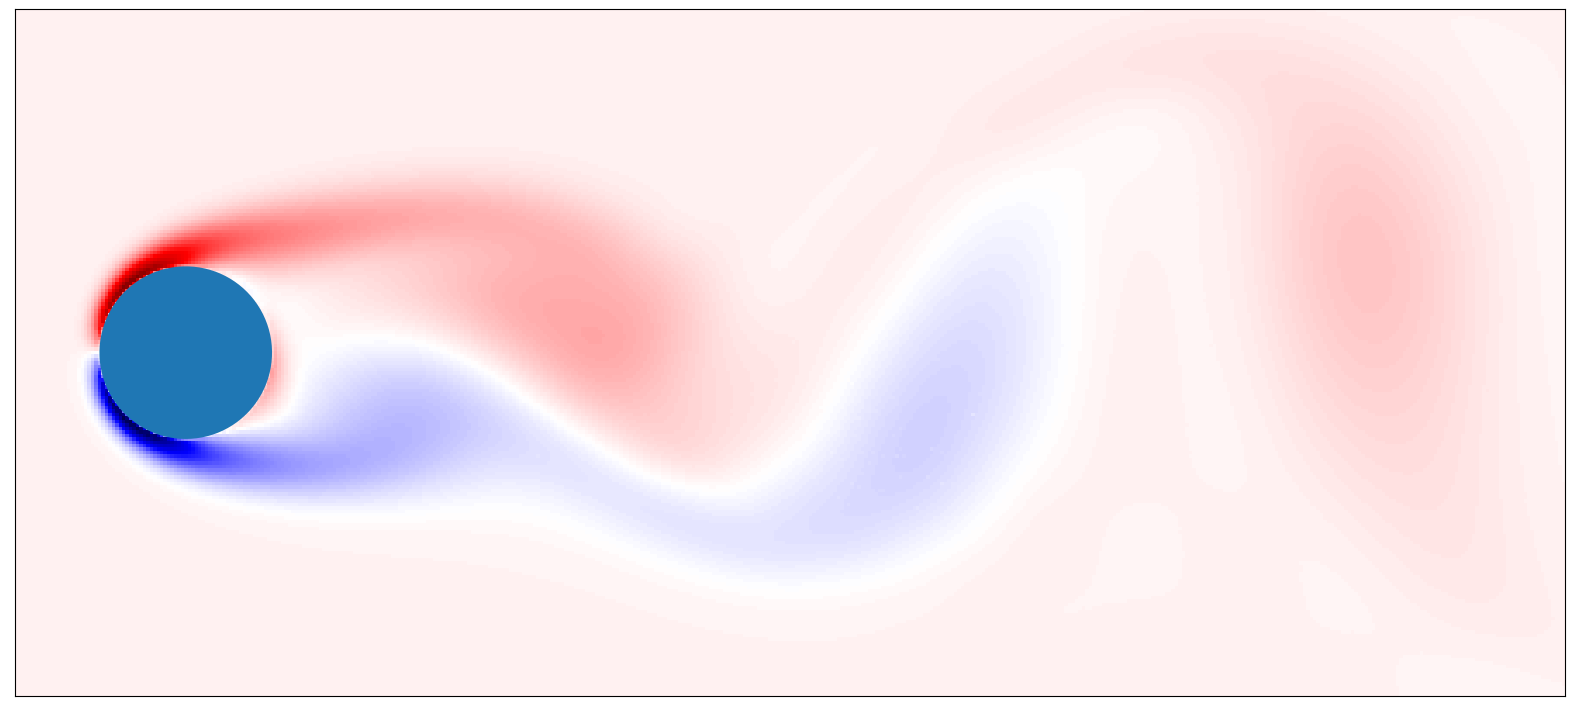

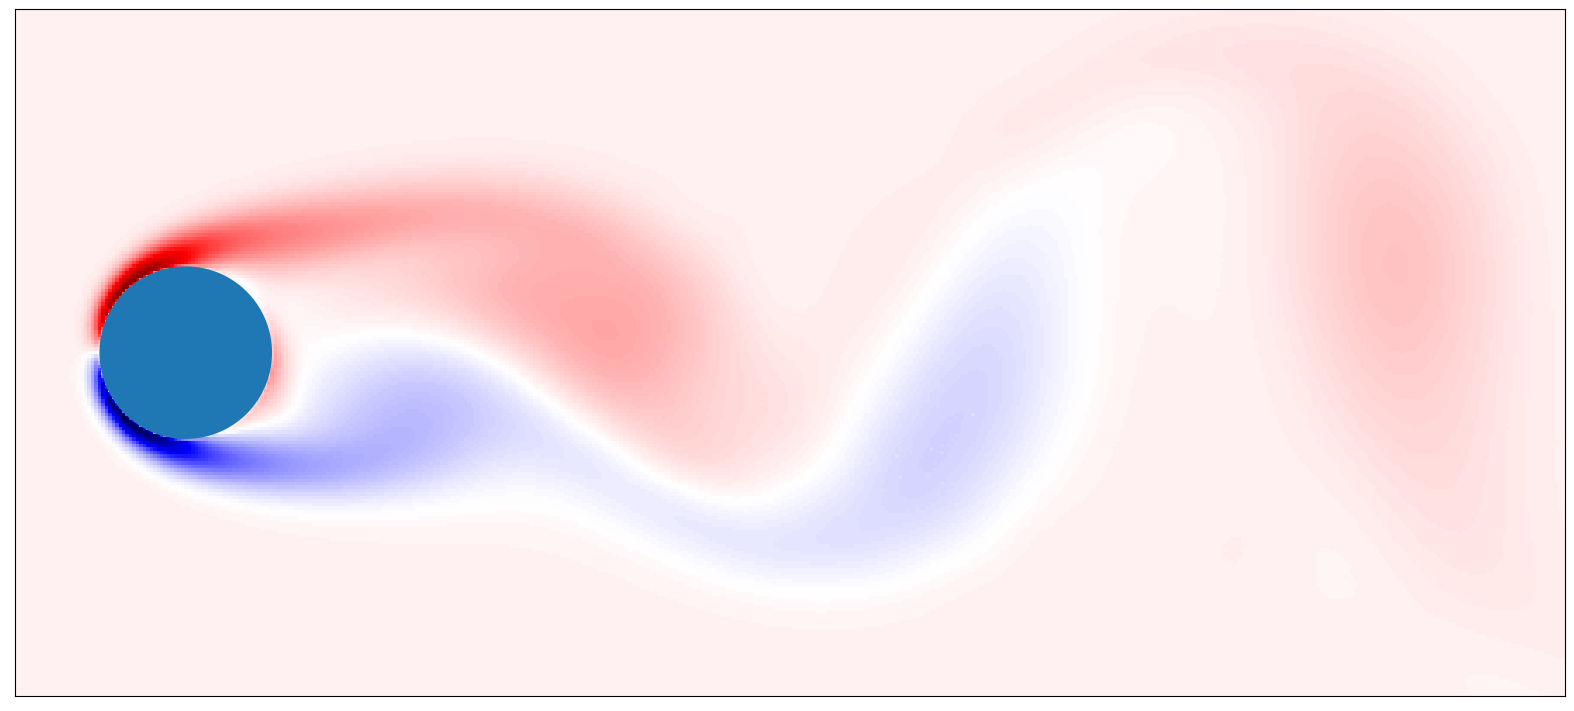

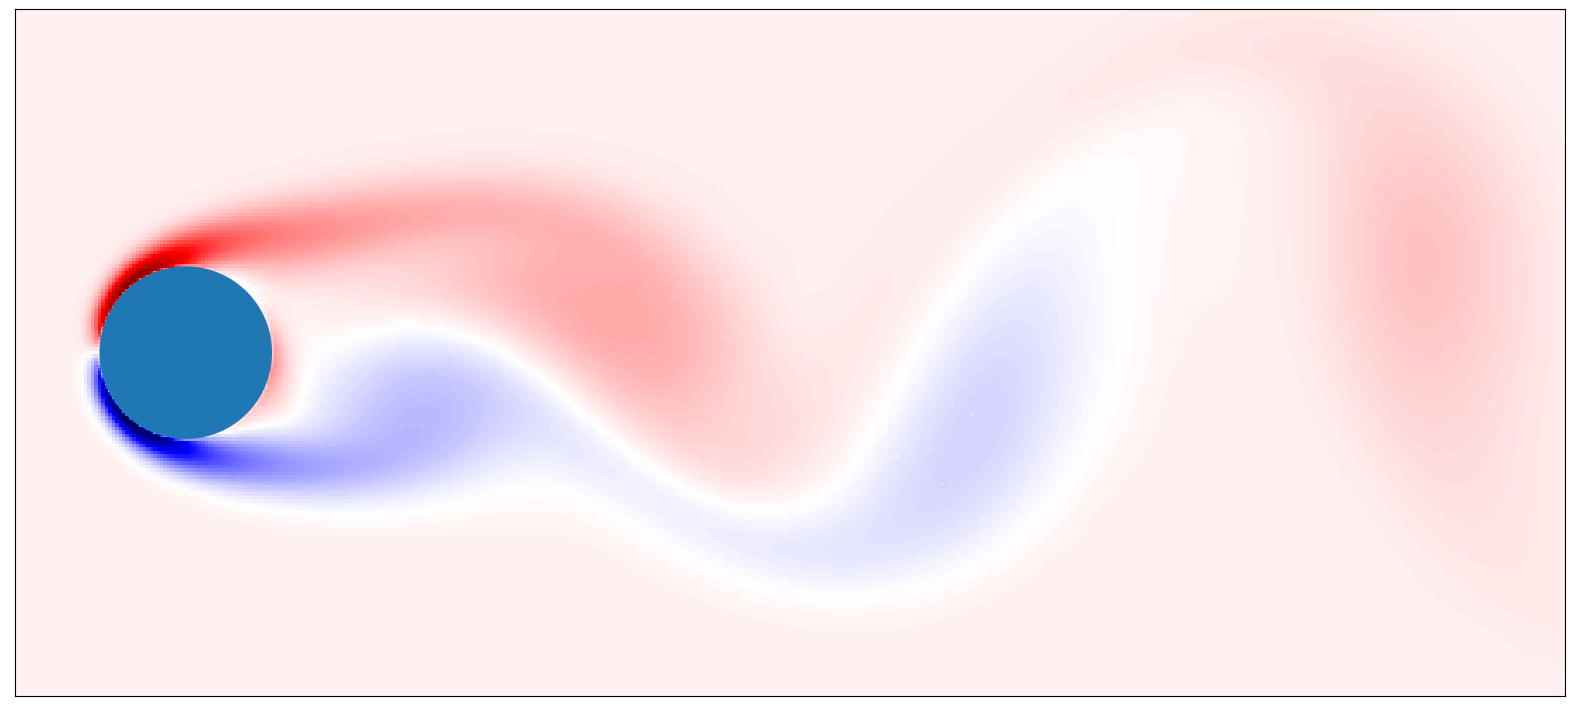

In [43]:
plot(X_hat.T.reshape((ny, nx, 151)),3,'OSP_reconstructed')

<span style="color:blue; font-size:26px; font-weight:bold;">Modes of the reconstructed images from 10 OSP measurements</span>

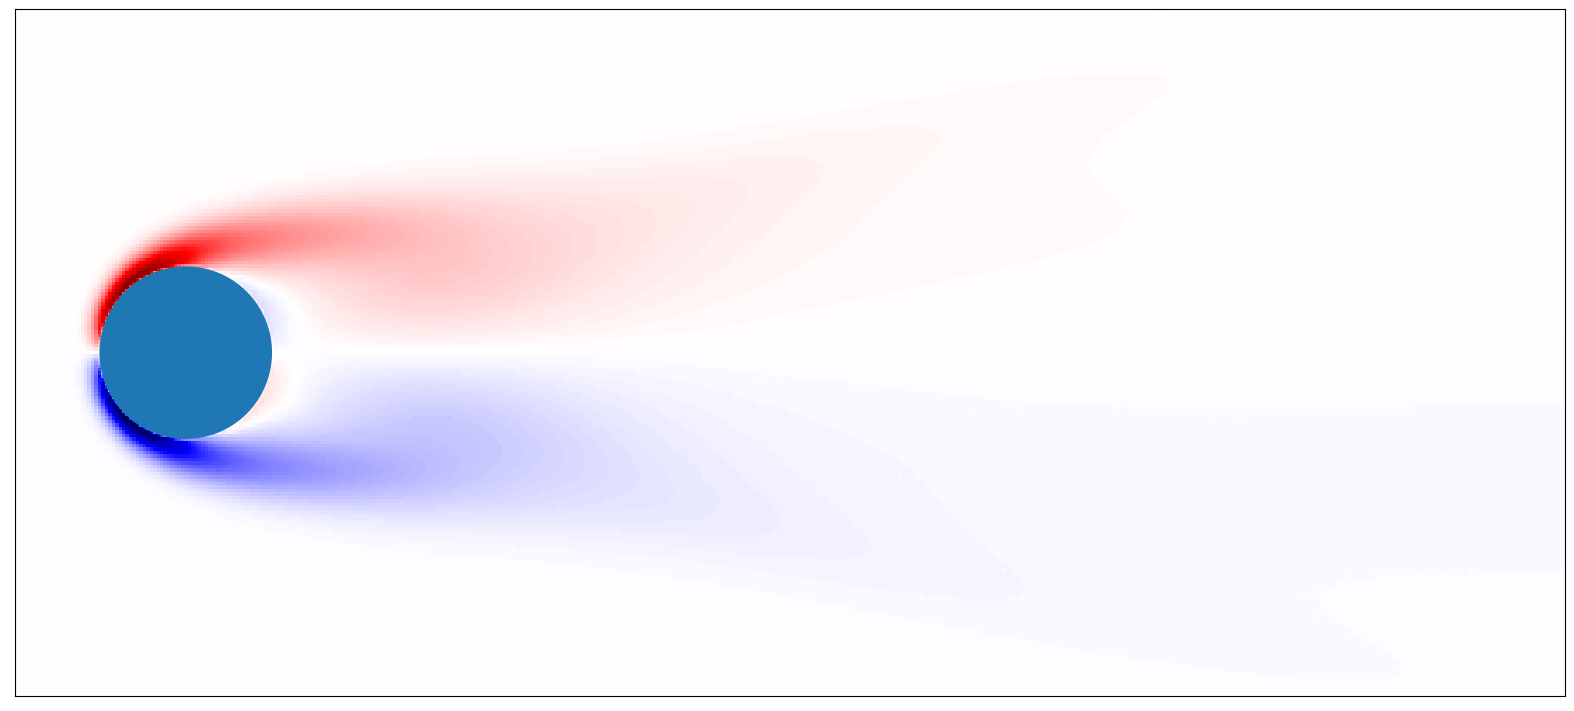

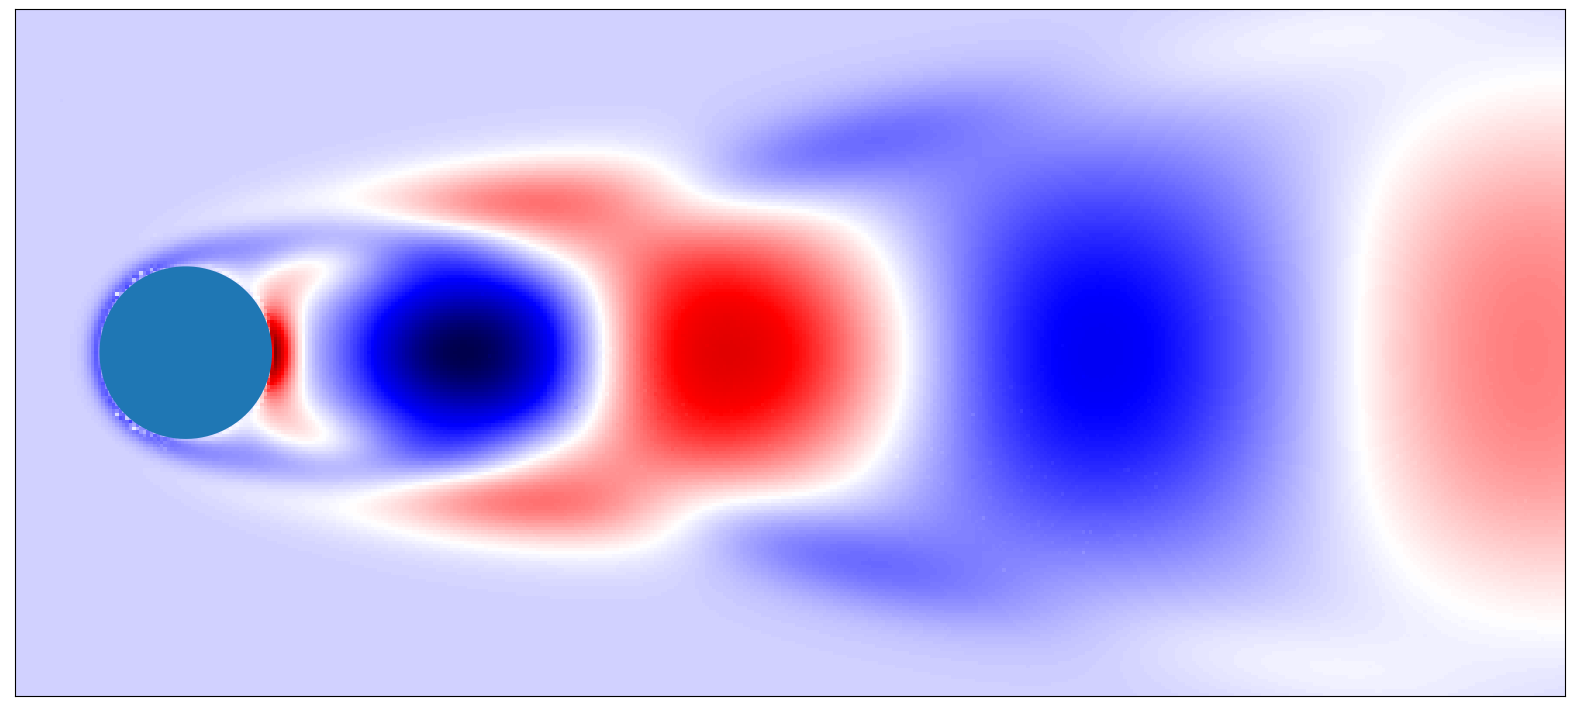

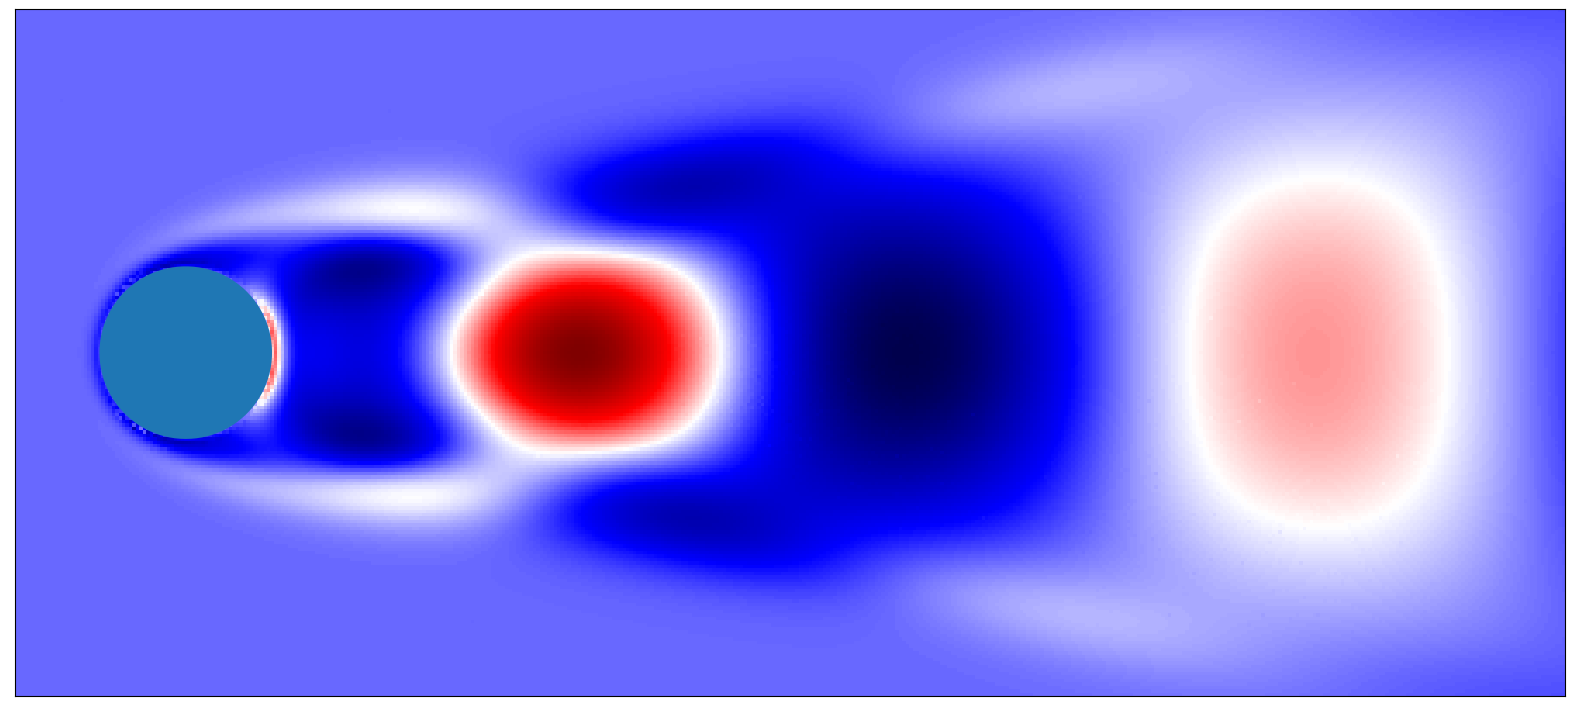

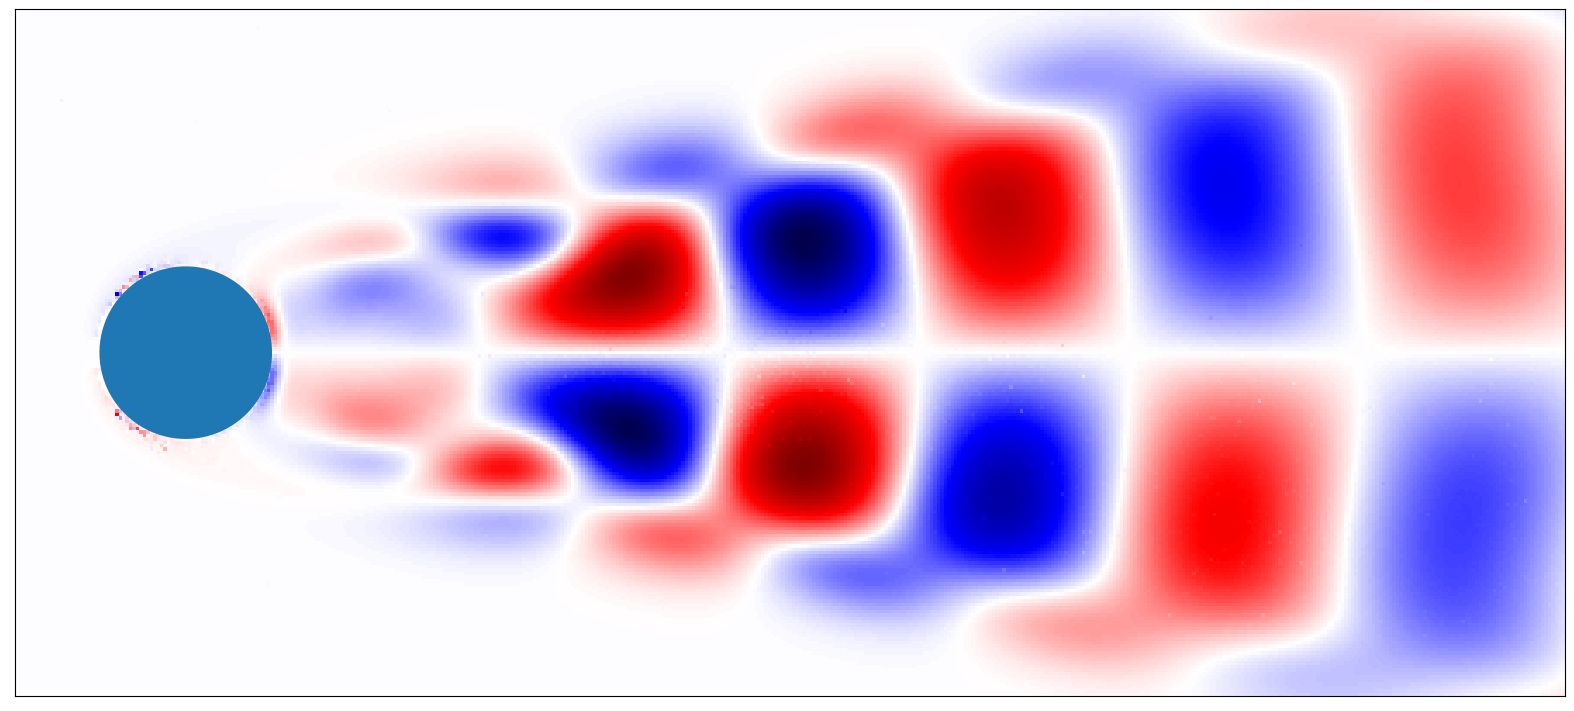

In [44]:
pca = PCA(n_components = num_components)  # project from 64 to 2 dimensions
score=pca.fit_transform(X_hat.T)
coeff=pca.components_ #eigen vectors.T
latent = pca.explained_variance_
explained = pca.explained_variance_ratio_
Phi = np.reshape(score,(ny,nx,num_components))

plot(Phi,4,'OSP_modes')

-------------------------------------------------------
-------------------------------------------------------
-------------------------------------------------------